# IF3170 Artificial Intelligence | Tugas Besar 2

This notebook serves as a template for the assignment. Please create a copy of this notebook to complete your work. You can add more code blocks, markdown blocks, or new sections if needed.


Group AK48  
Group Number: 25

Group Members:
- Aurelius Justin Philo Fanjaya (13522020)
- Bagas Sambega Rosyada (13522071)
- Fedrianz Dharma (13522090)
- Raden Francisco Trianto B. (13522091)

## Import Libraries

In [50]:
from IPython.display import Markdown, display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest
from sklearn.base import BaseEstimator, TransformerMixin


# Function to display markdown
def print_markdown(md_text):
    display(Markdown(md_text))

## Import Dataset

In [51]:
# Example of reading a csv file from a gdrive link

# Take the file id from the gdrive file url
# https://drive.google.com/file/d/1ZUtiaty9RPXhpz5F2Sy3dFPHF4YIt5iU/view?usp=sharing => The file id is 1ZUtiaty9RPXhpz5F2Sy3dFPHF4YIt5iU
# and then put it in this format:
# https://drive.google.com/uc?id={file_id}
# Don't forget to change the access to public

# Local path
train_path = "../dataset/train/"

basic_features_df = pd.read_csv(train_path + "basic_features_train.csv")
additional_features_df = pd.read_csv(train_path + "additional_features_train.csv")
content_features_df = pd.read_csv(train_path + "content_features_train.csv")
flow_features_df = pd.read_csv(train_path + "flow_features_train.csv")
time_features_df = pd.read_csv(train_path + "time_features_train.csv")
labels_df = pd.read_csv(train_path + "labels_train.csv").drop(columns=['label'])

df = basic_features_df.merge(additional_features_df, on="id") \
    .merge(content_features_df, on="id") \
    .merge(flow_features_df, on="id") \
    .merge(time_features_df, on="id") \
    .merge(labels_df, on="id").drop(columns=['id'])

print(df.head())

  state       dur   sbytes    dbytes   sttl   dttl  sloss  dloss service  \
0   FIN  2.736664  13350.0  548216.0   31.0   29.0   21.0  197.0       -   
1   INT  0.000009    114.0       0.0  254.0    0.0    0.0    0.0     dns   
2   FIN  5.788526   6102.0    3892.0  254.0  252.0   13.0   13.0       -   
3   FIN  3.849634  25160.0       NaN   31.0   29.0   38.0  390.0       -   
4   CON  0.001052    130.0     162.0    NaN   29.0    0.0    0.0     dns   

          sload  ...  response_body_len  proto         sjit         djit  \
0  3.885899e+04  ...                0.0    tcp  4449.110313  3234.831566   
1  5.066666e+07  ...                0.0    udp     0.000000     0.000000   
2  8.199669e+03  ...                0.0    tcp  8561.040438   249.950547   
3  5.216912e+04  ...                0.0    tcp  4053.086020  2918.730804   
4  4.942966e+05  ...                0.0    udp     0.000000     0.000000   

       sinpkt      dinpkt    tcprtt    synack    ackdat  attack_cat  
0   11.845558   

# Exploratory Data Analysis (Optional)

Exploratory Data Analysis (EDA) is a crucial step in the data analysis process that involves examining and visualizing data sets to uncover patterns, trends, anomalies, and insights. It is the first step before applying more advanced statistical and machine learning techniques. EDA helps you to gain a deep understanding of the data you are working with, allowing you to make informed decisions and formulate hypotheses for further analysis.

### 1. Data Size

In [52]:
### 1. Data Size
print(f"Number of instances: {df.shape[0]} | Number of features: {df.shape[1] - 1}")
print(f"Target class: attack_cat")

Number of instances: 175341 | Number of features: 41
Target class: attack_cat


### 2. Features and Target

In [53]:
target_col: list[str] = ["attack_cat"]
categorical_features: list[str] = ["state", "service", "proto","is_ftp_login", "is_sm_ips_ports"]
numerical_features: list[str] = [col for col in df.columns if col not in categorical_features and col not in target_col and col != 'id']

df_categorical: pd.DataFrame = df[categorical_features]
df_numeric: pd.DataFrame = df[numerical_features]

print("Target Collumn:", target_col)
print("Categorical Features:", categorical_features)
print("Numerical Features:", numerical_features)

Target Collumn: ['attack_cat']
Categorical Features: ['state', 'service', 'proto', 'is_ftp_login', 'is_sm_ips_ports']
Numerical Features: ['dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'sload', 'dload', 'spkts', 'dpkts', 'ct_state_ttl', 'ct_flw_http_mthd', 'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'swin', 'dwin', 'stcpb', 'dtcpb', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'sjit', 'djit', 'sinpkt', 'dinpkt', 'tcprtt', 'synack', 'ackdat']


### 3. Data Types

In [54]:
print(df.dtypes.to_string())

state                 object
dur                  float64
sbytes               float64
dbytes               float64
sttl                 float64
dttl                 float64
sloss                float64
dloss                float64
service               object
sload                float64
dload                float64
spkts                float64
dpkts                float64
is_sm_ips_ports      float64
ct_state_ttl         float64
ct_flw_http_mthd     float64
is_ftp_login         float64
ct_ftp_cmd           float64
ct_srv_src           float64
ct_srv_dst           float64
ct_dst_ltm           float64
ct_src_ltm           float64
ct_src_dport_ltm     float64
ct_dst_sport_ltm     float64
ct_dst_src_ltm       float64
swin                 float64
dwin                 float64
stcpb                float64
dtcpb                float64
smean                float64
dmean                float64
trans_depth          float64
response_body_len    float64
proto                 object
sjit          

### 4. Missing Values

In [55]:
missing_counts = df.isnull().sum()
total_rows = len(df)

# Calculate the percentage of missing data for each column
missing_percentage = (missing_counts / total_rows) * 100

missing_data_summary = pd.DataFrame({'Missing Values': missing_counts, 'Percentage': missing_percentage})

# Sort by the percentage of missing data (optional)
missing_data_summary = missing_data_summary.sort_values(by='Percentage', ascending=False)

print(missing_data_summary)


                   Missing Values  Percentage
dloss                        8978    5.120308
ct_dst_src_ltm               8895    5.072972
dbytes                       8869    5.058144
dmean                        8855    5.050159
ct_srv_src                   8851    5.047878
djit                         8846    5.045027
ct_ftp_cmd                   8842    5.042745
dload                        8837    5.039894
tcprtt                       8836    5.039323
proto                        8826    5.033620
sttl                         8825    5.033050
ct_src_ltm                   8823    5.031909
state                        8805    5.021644
dtcpb                        8803    5.020503
sloss                        8794    5.015370
response_body_len            8791    5.013659
service                      8791    5.013659
smean                        8788    5.011948
ct_dst_sport_ltm             8788    5.011948
sload                        8786    5.010808
trans_depth                  8785 

### 5. Unique Values for Categorical

In [56]:
for col in categorical_features:
    print(f"Column {col}: {df[col].dropna().nunique()}")

Column state: 9
Column service: 13
Column proto: 133
Column is_ftp_login: 4
Column is_sm_ips_ports: 2


### 6. Value Distribution

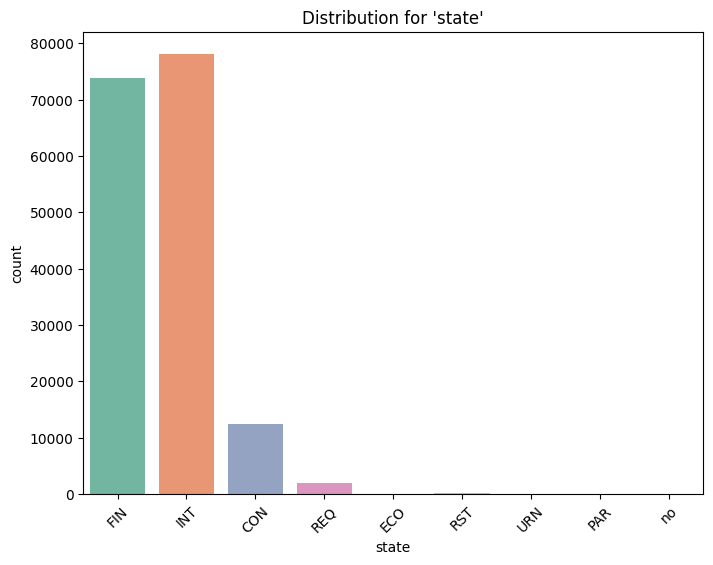

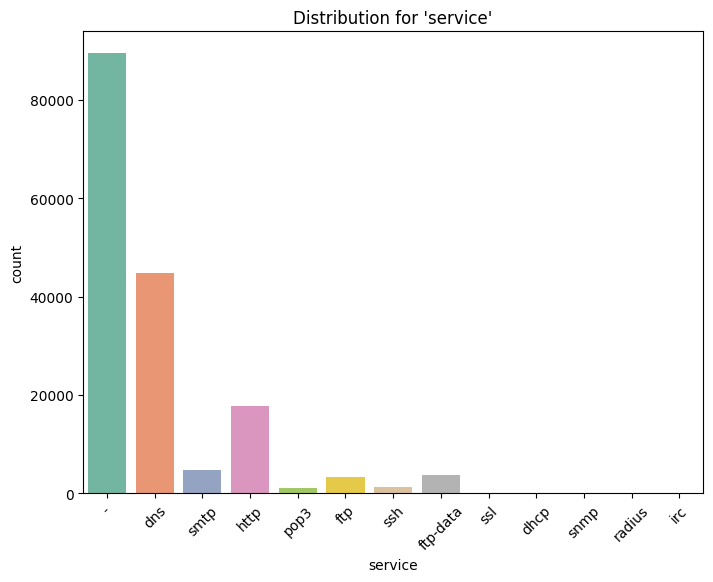

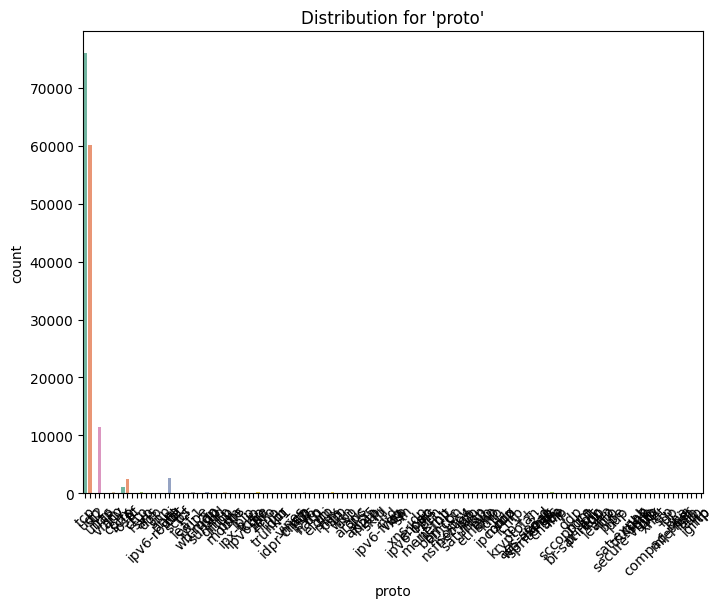

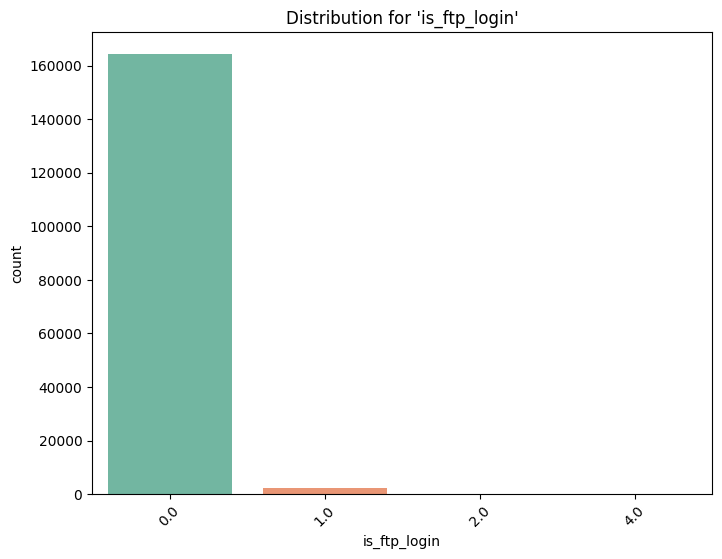

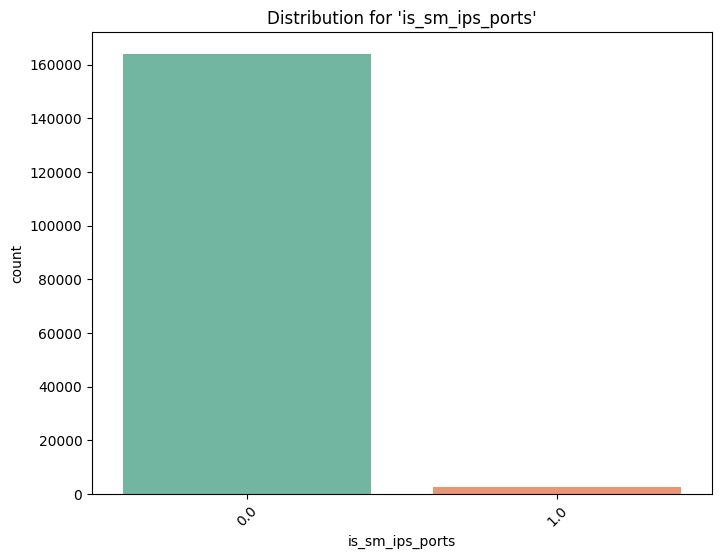

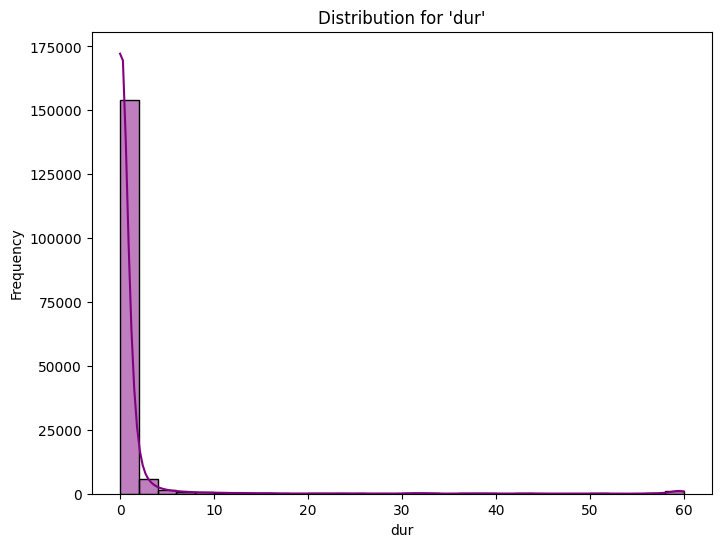

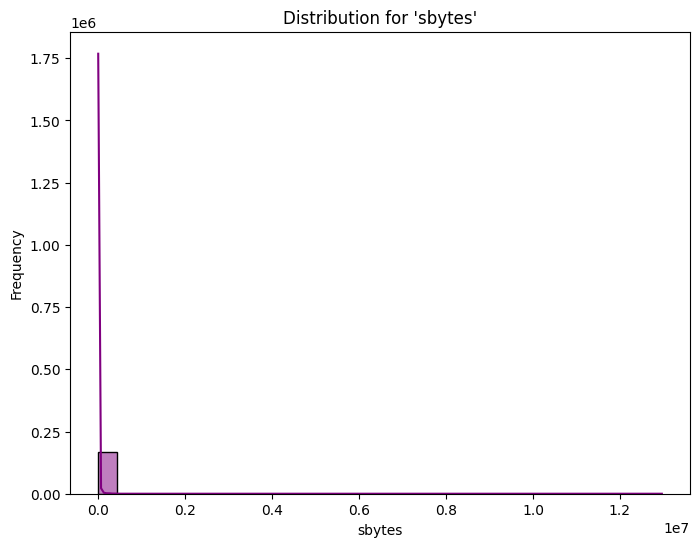

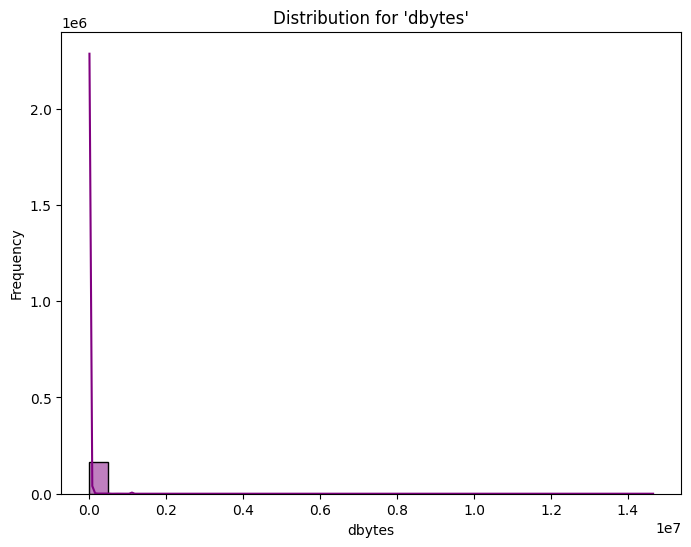

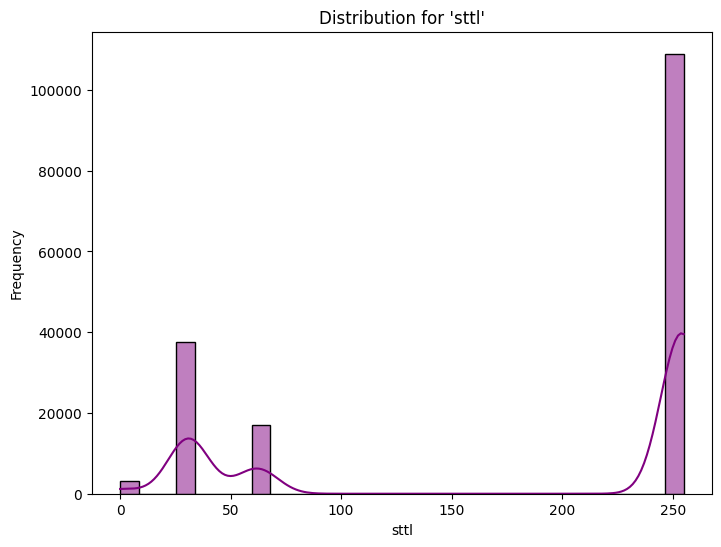

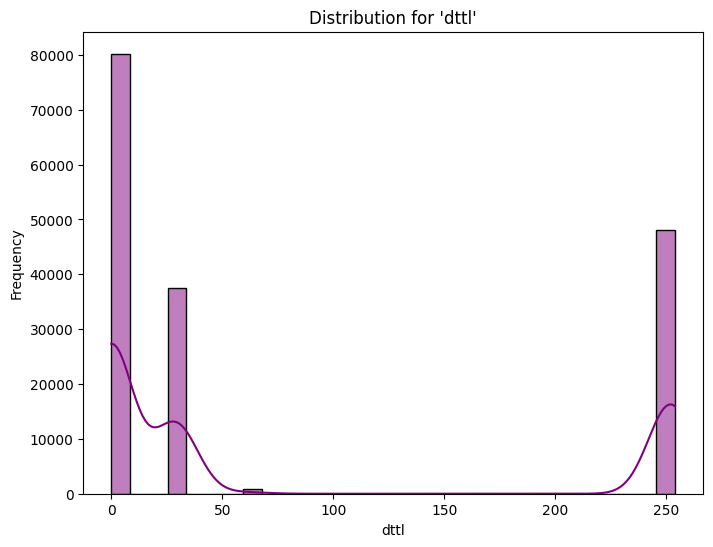

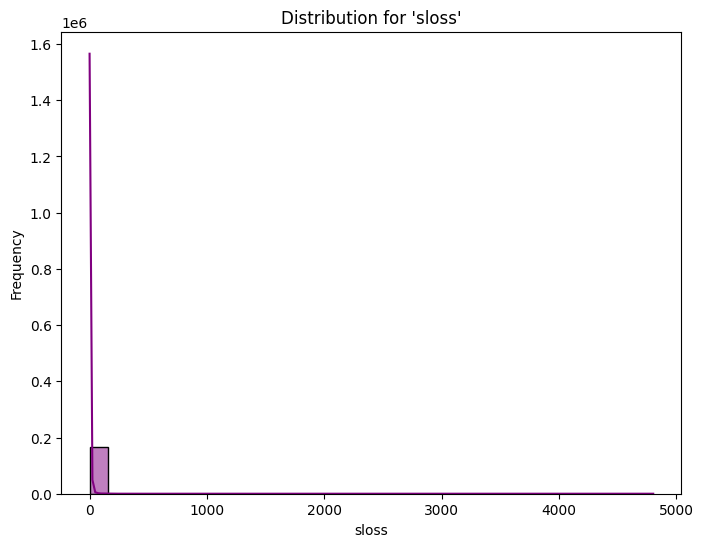

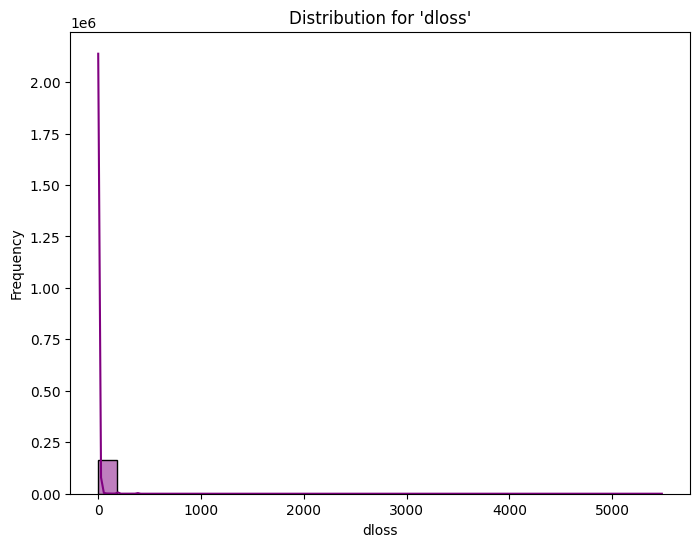

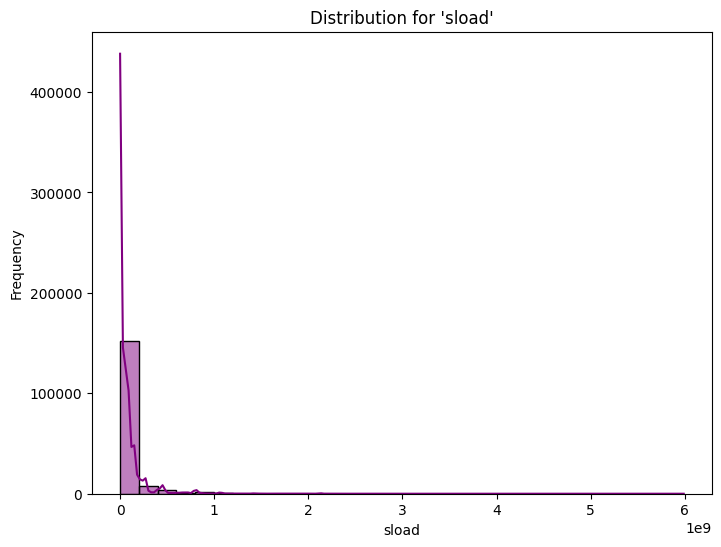

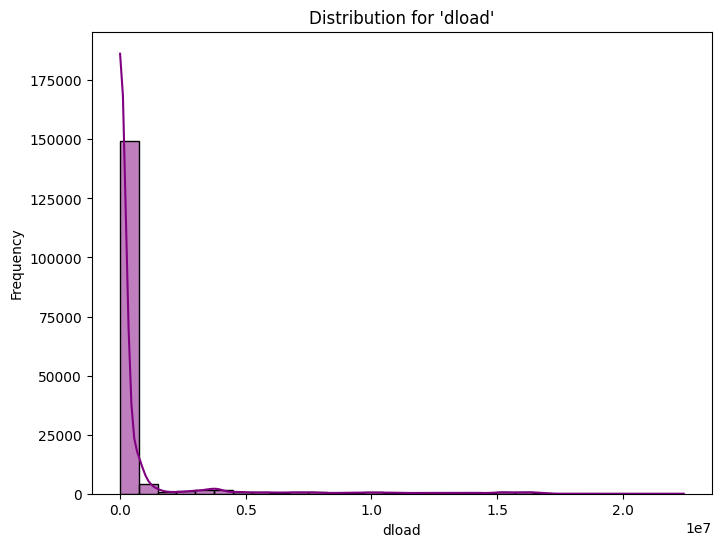

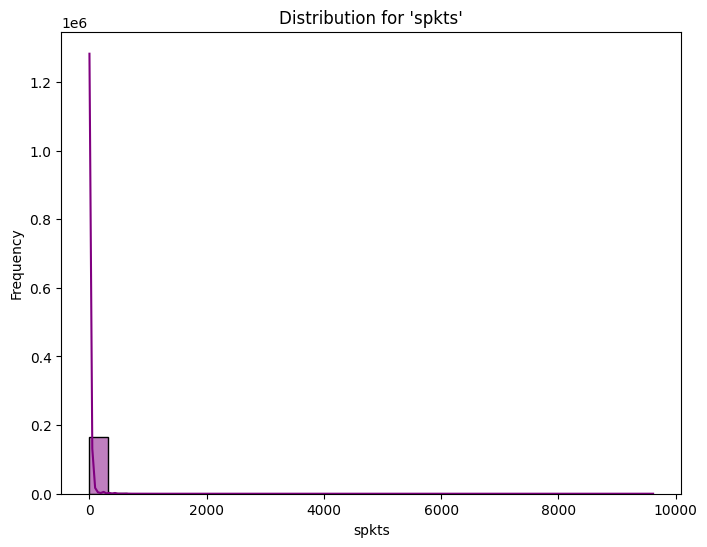

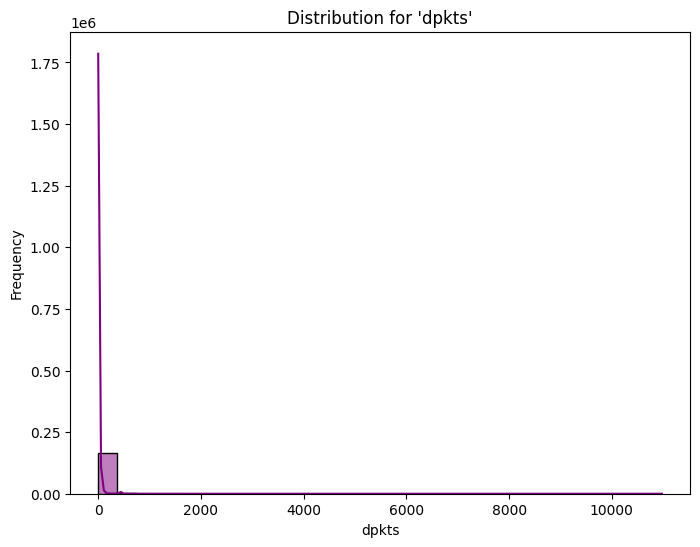

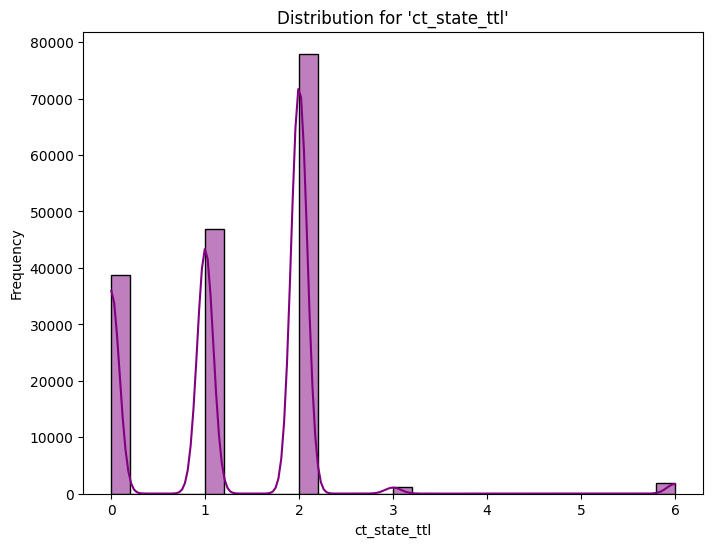

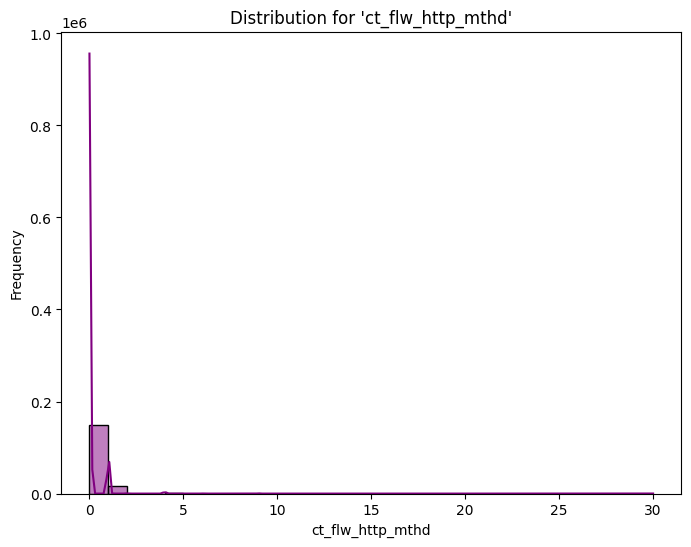

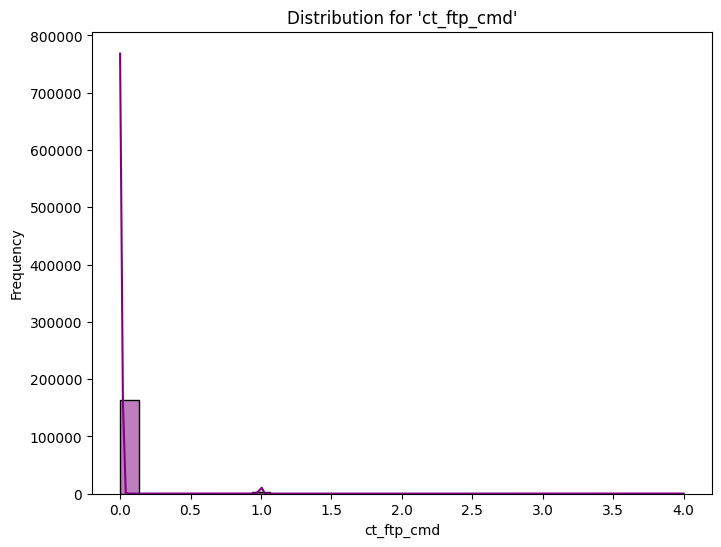

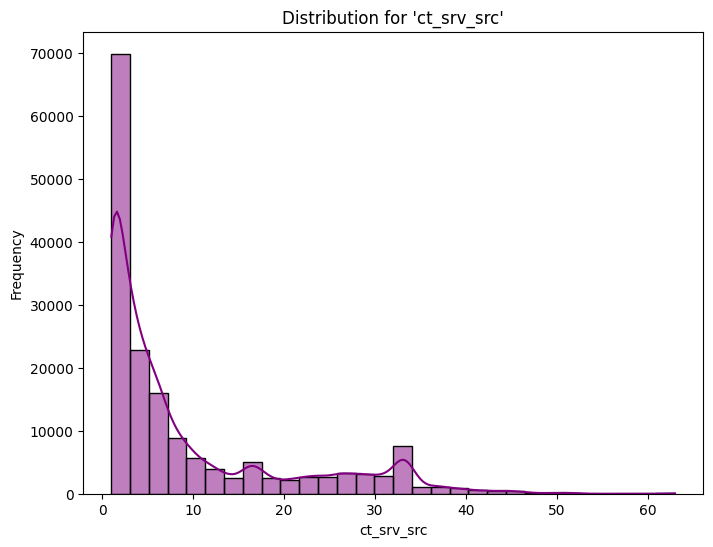

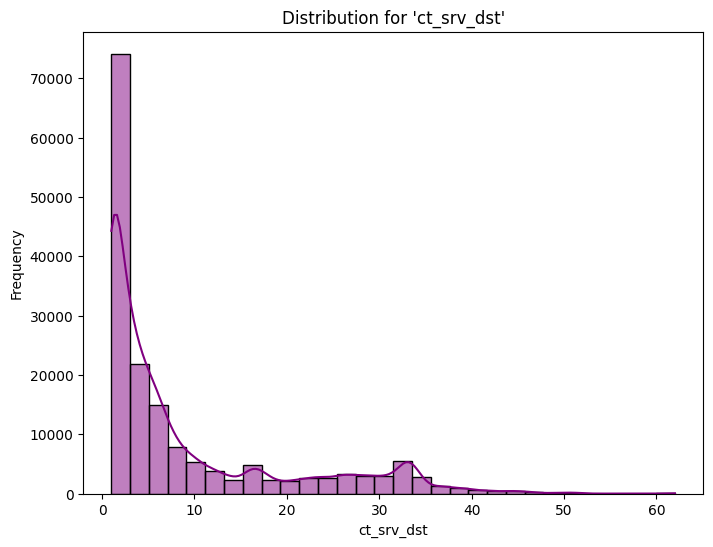

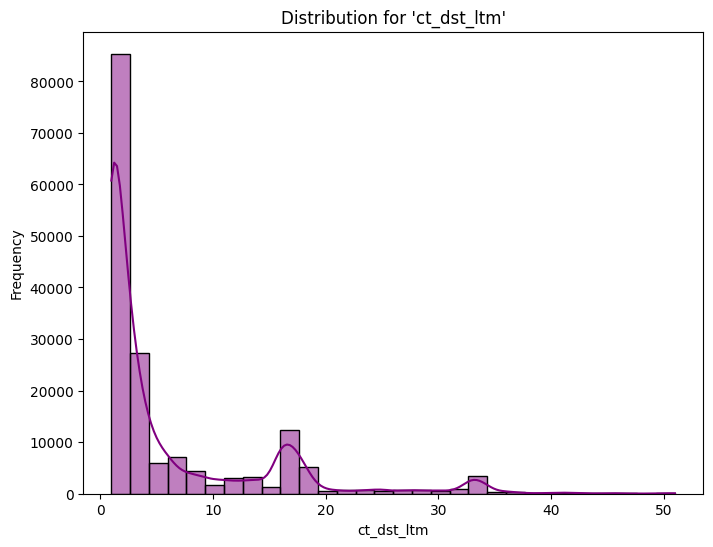

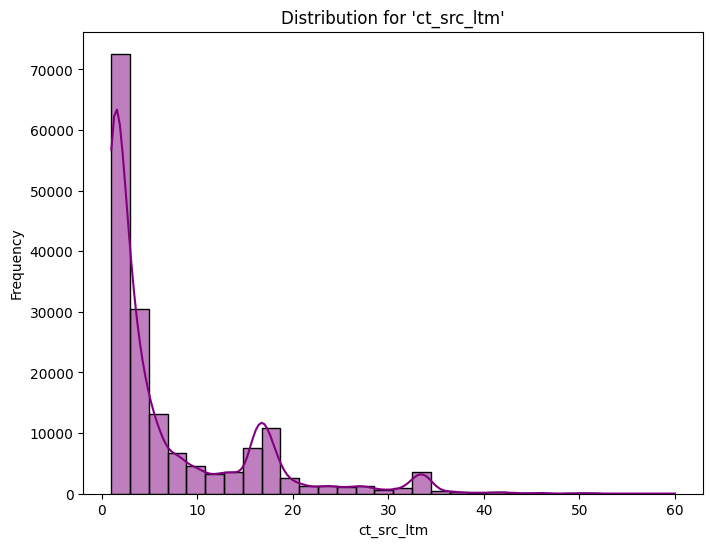

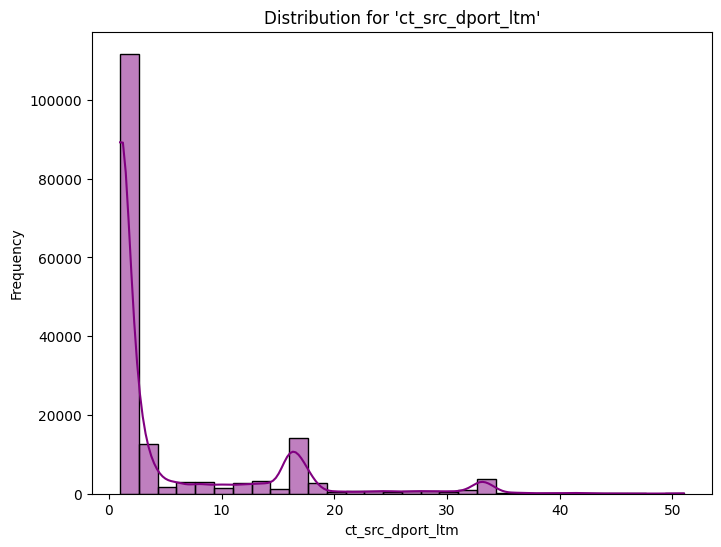

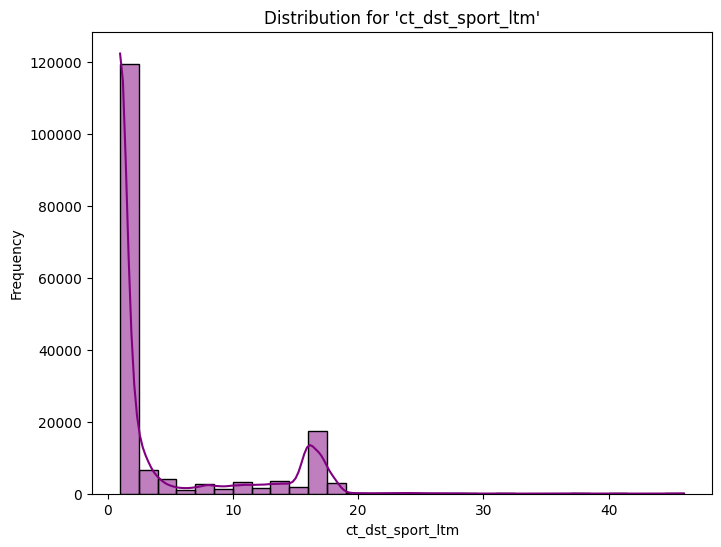

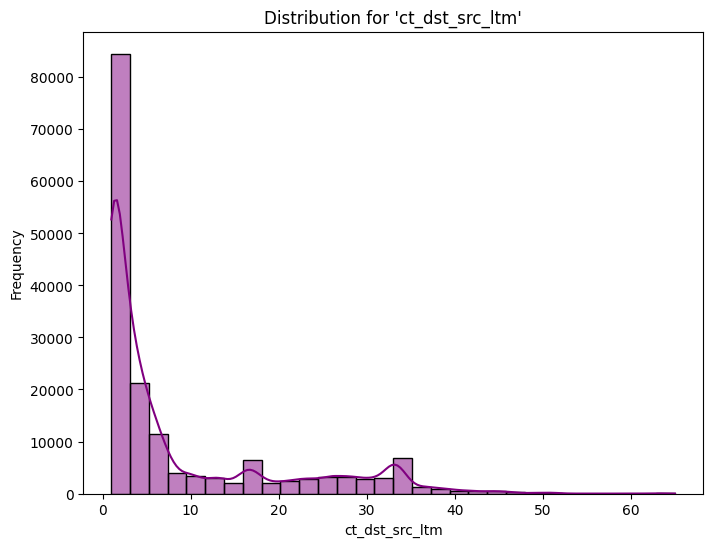

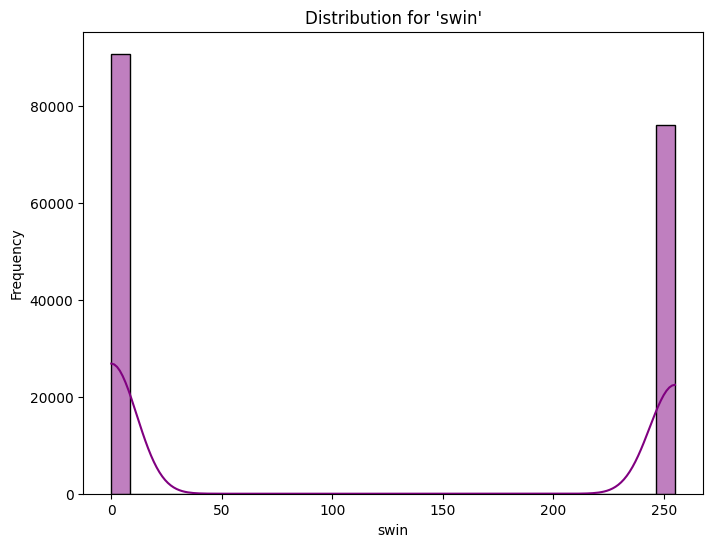

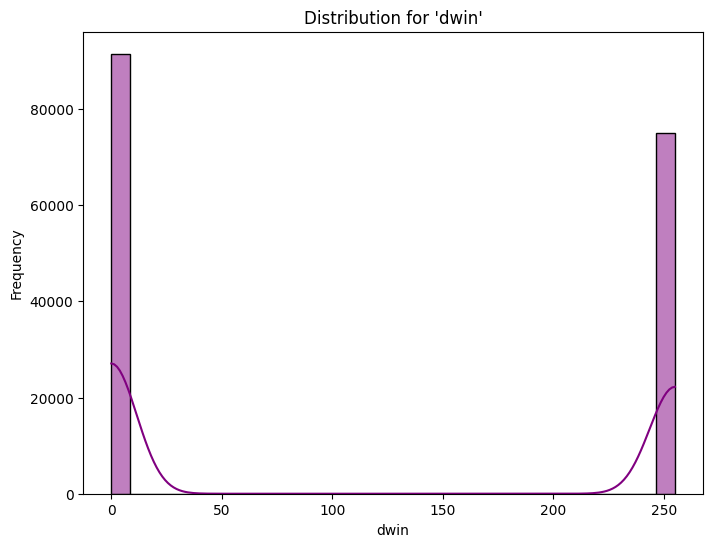

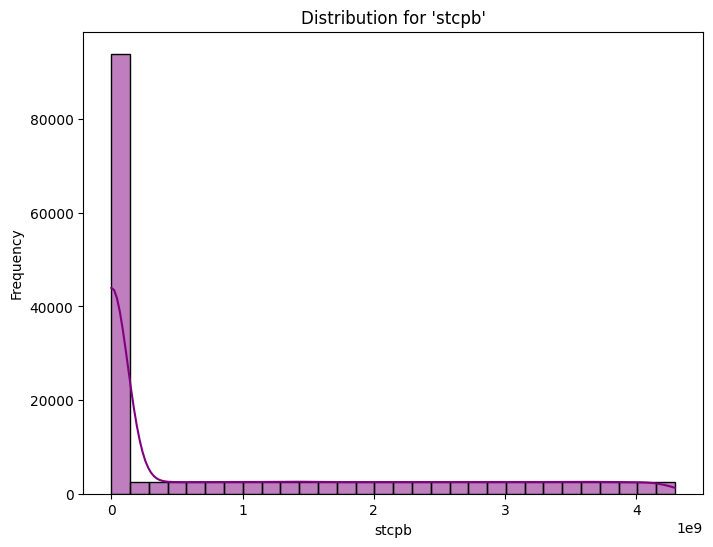

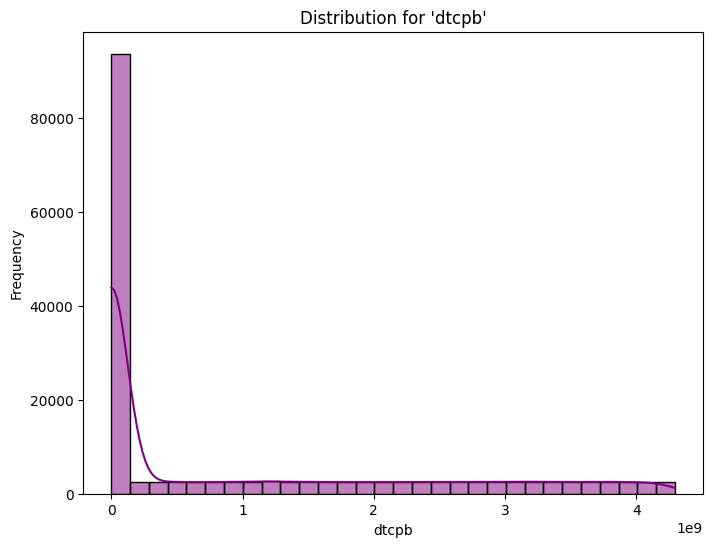

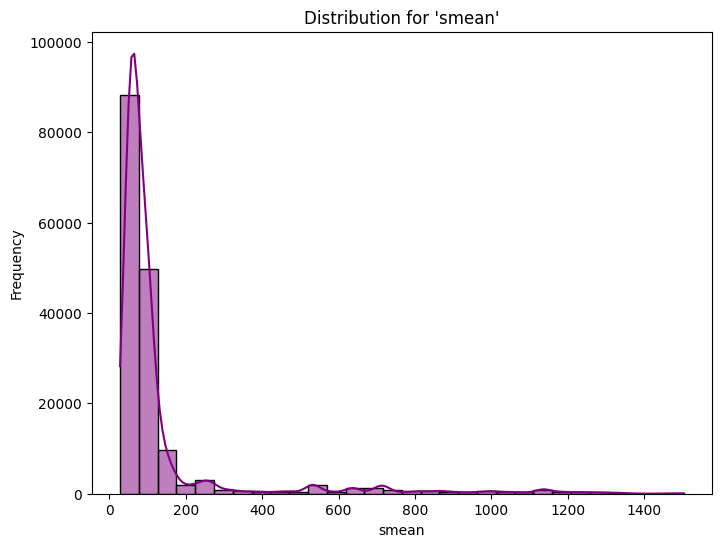

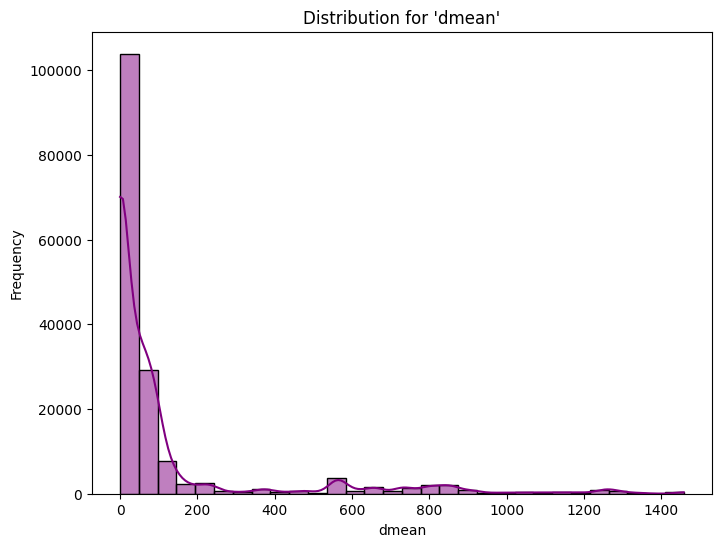

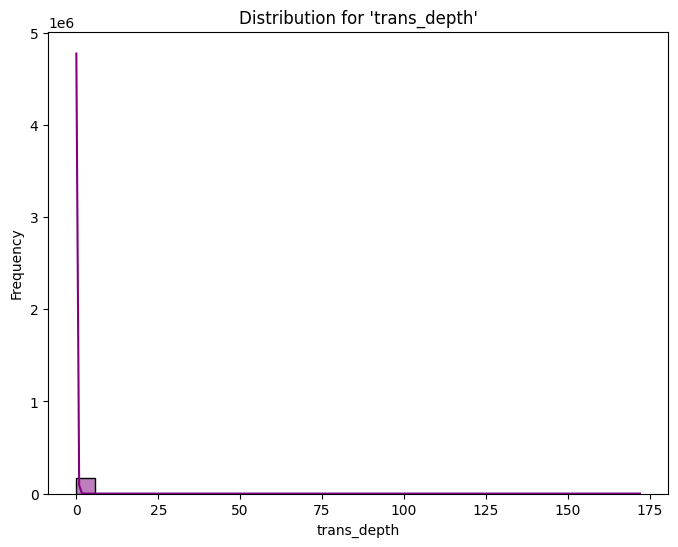

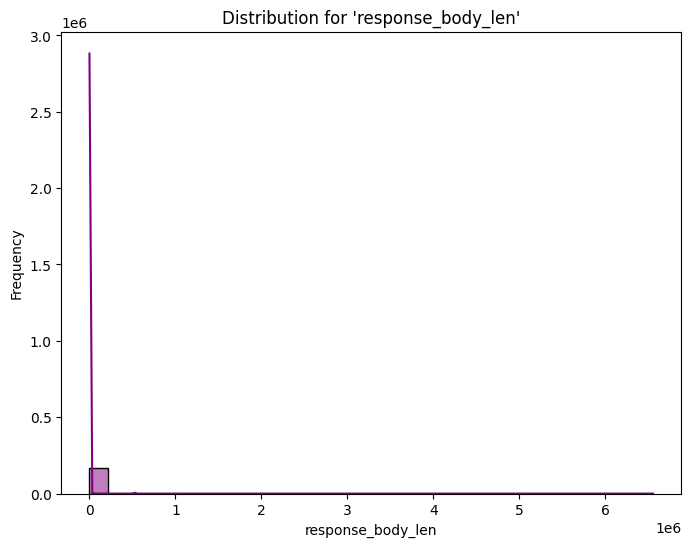

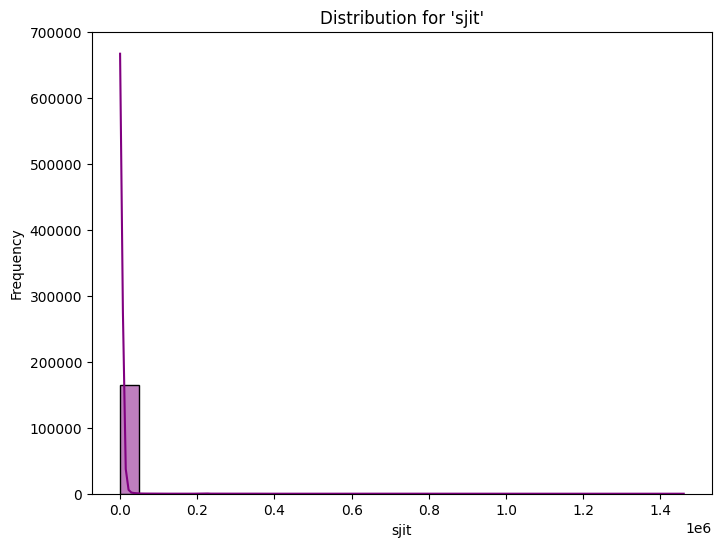

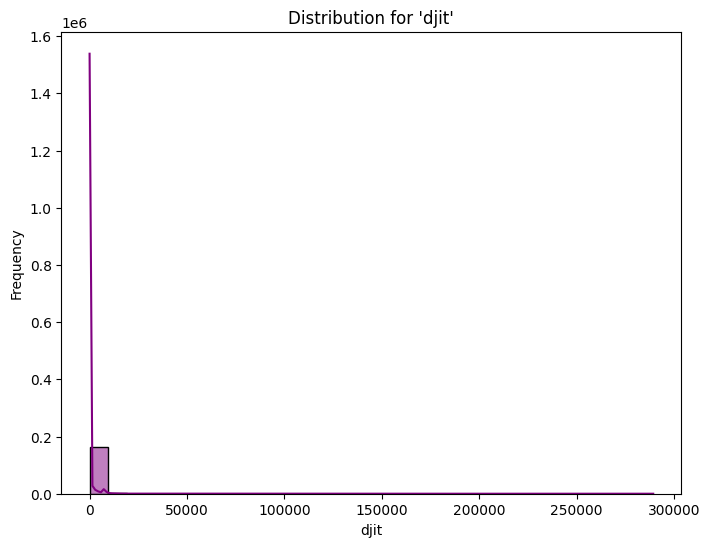

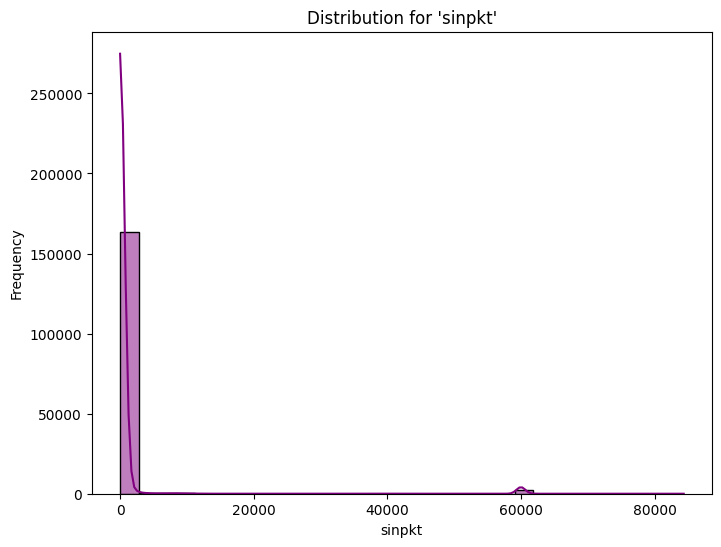

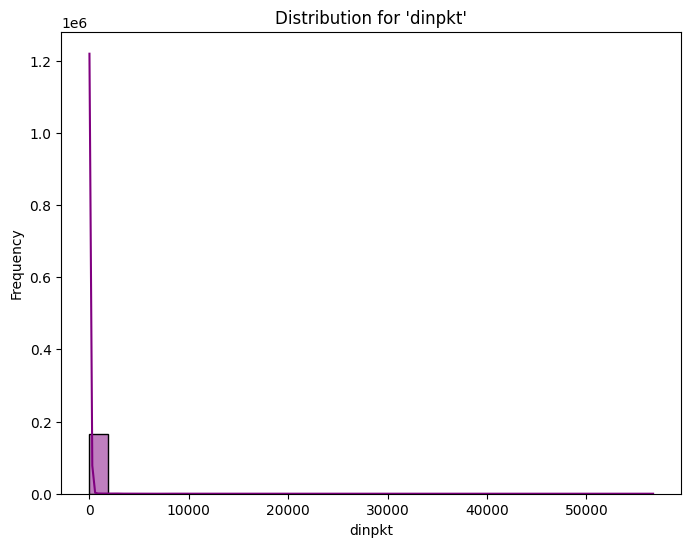

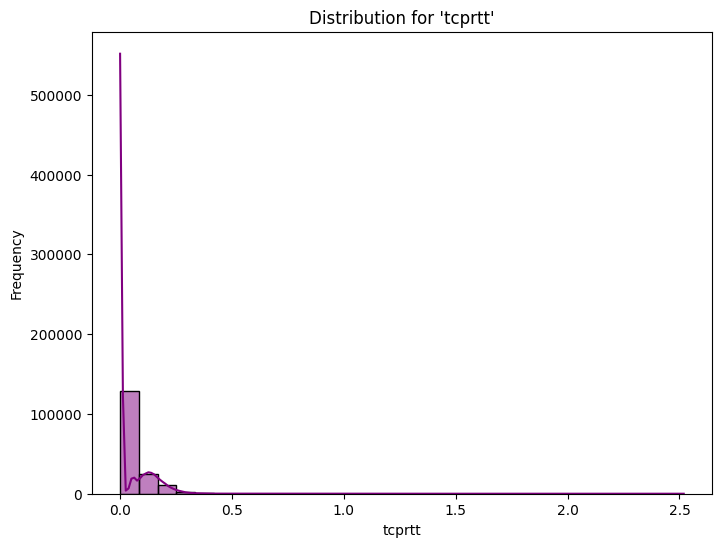

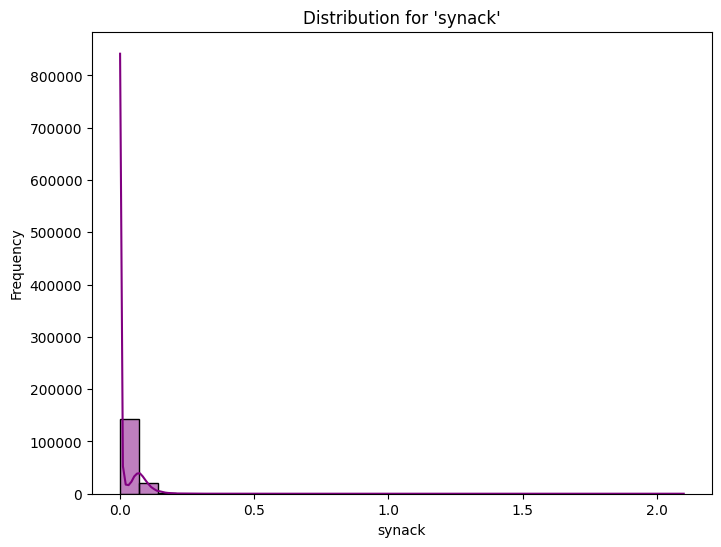

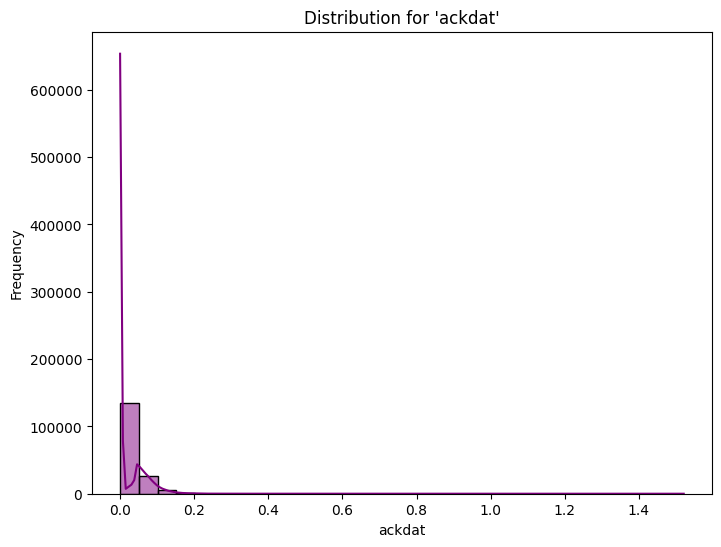

In [57]:
# Categorical column distribution plot
for col in categorical_features:
    plt.figure(figsize=(8, 6))
    sns.countplot(x=df[col].dropna(), palette='Set2', hue=df[col], legend=False)
    plt.title(f"Distribution for '{col}'")
    plt.xticks(rotation=45)
    plt.show()

# Numerical column distribution plot (using histograms)
for col in numerical_features:
    plt.figure(figsize=(8, 6))
    sns.histplot(df[col].dropna(), kde=True, bins=30, color='purple')
    plt.title(f"Distribution for '{col}'")
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

### 7. Outliers

In [58]:
# Outlier detection for numerical features (IQR method)
outlier_stats = []

for col in numerical_features:
    # Calculate Q1, Q3, and IQR
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identifying outliers
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outlier_count = outliers.shape[0]
    outlier_percentage = (outlier_count / df.shape[0]) * 100

    # Append the stats to the list
    outlier_stats.append((col, outlier_count, outlier_percentage))

# Sort the stats by percentage of outliers in descending order
outlier_stats.sort(key=lambda x: x[2], reverse=True)

# Print the sorted outlier statistics
for col, count, percentage in outlier_stats:
    print(f"Outliers for '{col}' Count: {count} | Percentage: {percentage:.2f}%")


Outliers for 'dload' Count: 36132 | Percentage: 20.61%
Outliers for 'ct_dst_sport_ltm' Count: 35385 | Percentage: 20.18%
Outliers for 'ct_src_dport_ltm' Count: 31801 | Percentage: 18.14%
Outliers for 'synack' Count: 29934 | Percentage: 17.07%
Outliers for 'dloss' Count: 26996 | Percentage: 15.40%
Outliers for 'dbytes' Count: 26698 | Percentage: 15.23%
Outliers for 'spkts' Count: 23470 | Percentage: 13.39%
Outliers for 'dmean' Count: 22185 | Percentage: 12.65%
Outliers for 'sbytes' Count: 21760 | Percentage: 12.41%
Outliers for 'ct_dst_ltm' Count: 21021 | Percentage: 11.99%
Outliers for 'dpkts' Count: 19752 | Percentage: 11.26%
Outliers for 'smean' Count: 19690 | Percentage: 11.23%
Outliers for 'djit' Count: 19538 | Percentage: 11.14%
Outliers for 'ct_srv_dst' Count: 18380 | Percentage: 10.48%
Outliers for 'ct_srv_src' Count: 18379 | Percentage: 10.48%
Outliers for 'sjit' Count: 17146 | Percentage: 9.78%
Outliers for 'ct_flw_http_mthd' Count: 16996 | Percentage: 9.69%
Outliers for 'tran

### 8. Mean, Median, Average, Min, Max for Numerical Features

In [59]:
df[numerical_features].describe()

,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,sload,dload,spkts,...,dmean,trans_depth,response_body_len,sjit,djit,sinpkt,dinpkt,tcprtt,synack,ackdat
count,166619.000000,1.667800e+05,1.664720e+05,166516.000000,166687.000000,166547.000000,166363.000000,1.665550e+05,1.665040e+05,166687.000000,...,166486.000000,166556.000000,1.665500e+05,1.666030e+05,166495.000000,166634.000000,166607.000000,166505.000000,166605.000000,166746.000000
mean,1.359299,8.734079e+03,1.493589e+04,179.521944,79.584179,4.904790,6.971688,7.342186e+07,6.718596e+05,20.266134,...,124.161041,0.106193,2.157133e+03,4.993982e+03,604.891720,987.360974,87.763617,0.041331,0.021042,0.020402
std,6.485386,1.712289e+05,1.430150e+05,102.957427,110.494848,64.867849,51.801936,1.884564e+08,2.422879e+06,136.433895,...,258.265755,0.794070,5.509898e+04,4.506783e+04,4082.439167,7246.462797,987.040024,0.079428,0.043560,0.040619
min,0.000000,2.800000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,1.000000,...,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000008,1.140000e+02,0.000000e+00,62.000000,0.000000,0.000000,0.000000,1.303032e+04,0.000000e+00,2.000000,...,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.008000,0.000000,0.000000,0.000000,0.000000
50%,0.001548,4.500000e+02,1.640000e+02,254.000000,29.000000,0.000000,0.000000,8.714544e+05,1.426630e+03,2.000000,...,44.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.284723,0.006000,0.000000,0.000000,0.000000
75%,0.667311,1.418000e+03,1.096000e+03,254.000000,252.000000,3.000000,2.000000,8.888889e+07,2.807410e+04,12.000000,...,89.000000,0.000000,0.000000e+00,2.511184e+03,114.753348,55.205806,50.933127,0.065151,0.023235,0.038951
max,59.999989,1.296523e+07,1.465555e+07,255.000000,254.000000,4803.000000,5484.000000,5.988000e+09,2.242273e+07,9616.000000,...,1458.000000,172.000000,6.558056e+06,1.460480e+06,289388.269700,84371.496000,56716.824000,2.518893,2.100352,1.520884


### 9. Correlations between Features

Correlation between features only for non-categorical columns


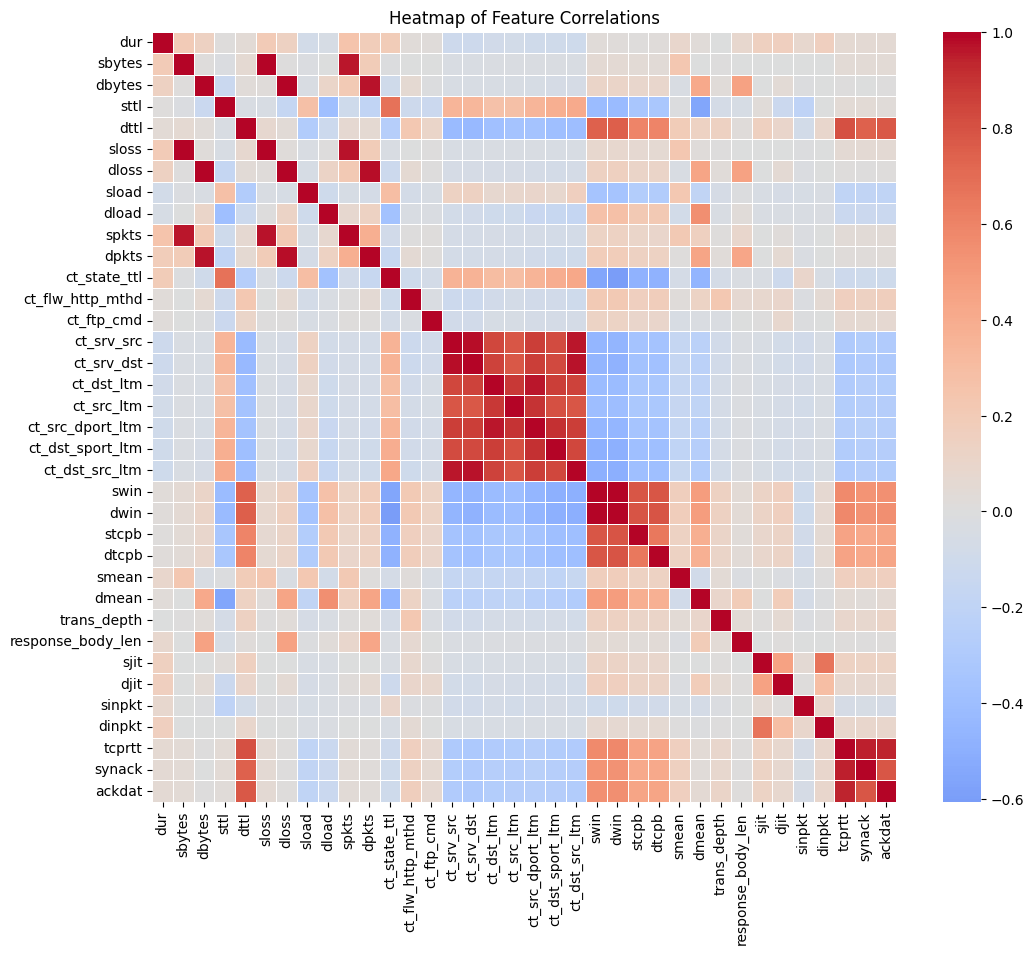

                        dur    sbytes    dbytes      sttl      dttl     sloss  \
dur                1.000000  0.202774  0.145071  0.011992  0.045195  0.197640   
sbytes             0.202774  1.000000  0.010087 -0.021082  0.063344  0.995869   
dbytes             0.145071  0.010087  1.000000 -0.135731  0.024822  0.017371   
sttl               0.011992 -0.021082 -0.135731  1.000000 -0.033042 -0.044240   
dttl               0.045195  0.063344  0.024822 -0.033042  1.000000  0.075353   
sloss              0.197640  0.995869  0.017371 -0.044240  0.075353  1.000000   
dloss              0.145543  0.007011  0.996416 -0.165732  0.036347  0.018578   
sload             -0.081312 -0.018519 -0.040463  0.275840 -0.280009 -0.028973   
dload             -0.050443 -0.007867  0.107409 -0.397367 -0.116282  0.008410   
spkts              0.255768  0.962399  0.205747 -0.101733  0.068295  0.969613   
dpkts              0.184342  0.188518  0.971798 -0.189196  0.054272  0.196450   
ct_state_ttl       0.188062 

In [60]:
print("Correlation between features only for non-categorical columns")
correlation = df_numeric.corr()

plt.figure(figsize=(12, 10))

sns.heatmap(correlation, annot=False, cmap='coolwarm', center=0, linewidths=0.5, fmt=".2f")

plt.title("Heatmap of Feature Correlations")
plt.show()

print(correlation)

#### Visualization of Correlation between Categorical Features and Non-Categorical Features

##### Correlation between state and non-categorical columns

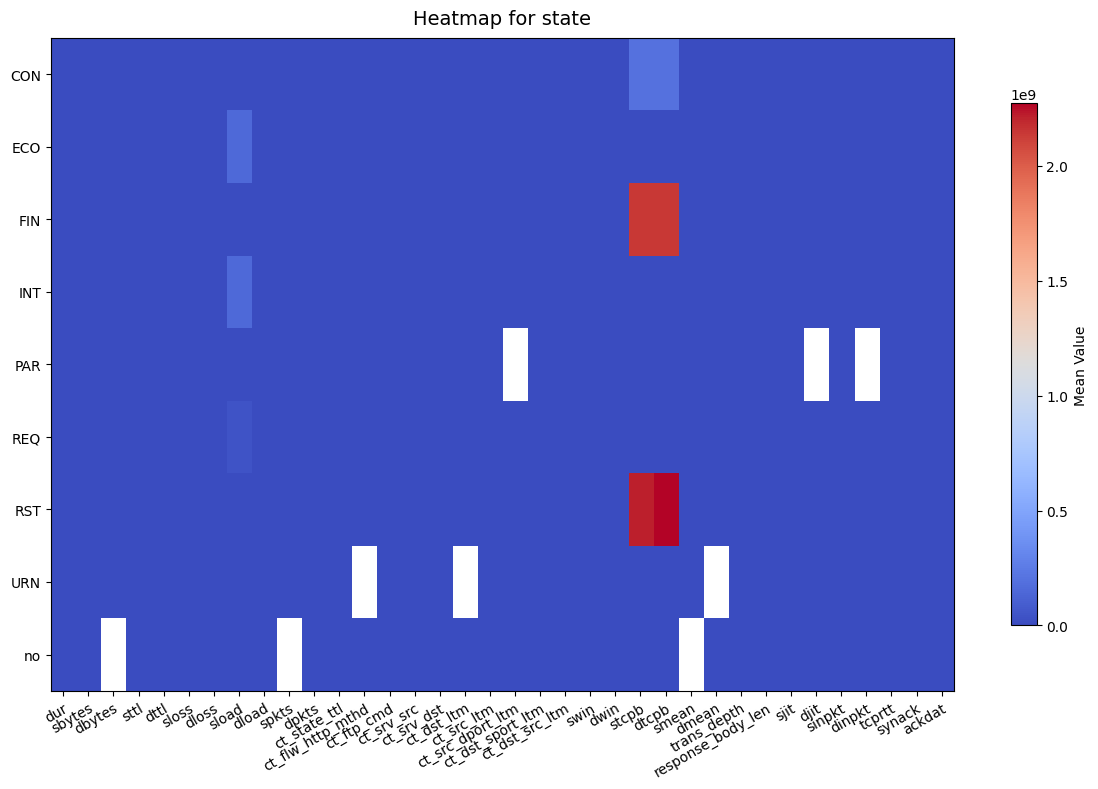

##### Correlation between service and non-categorical columns

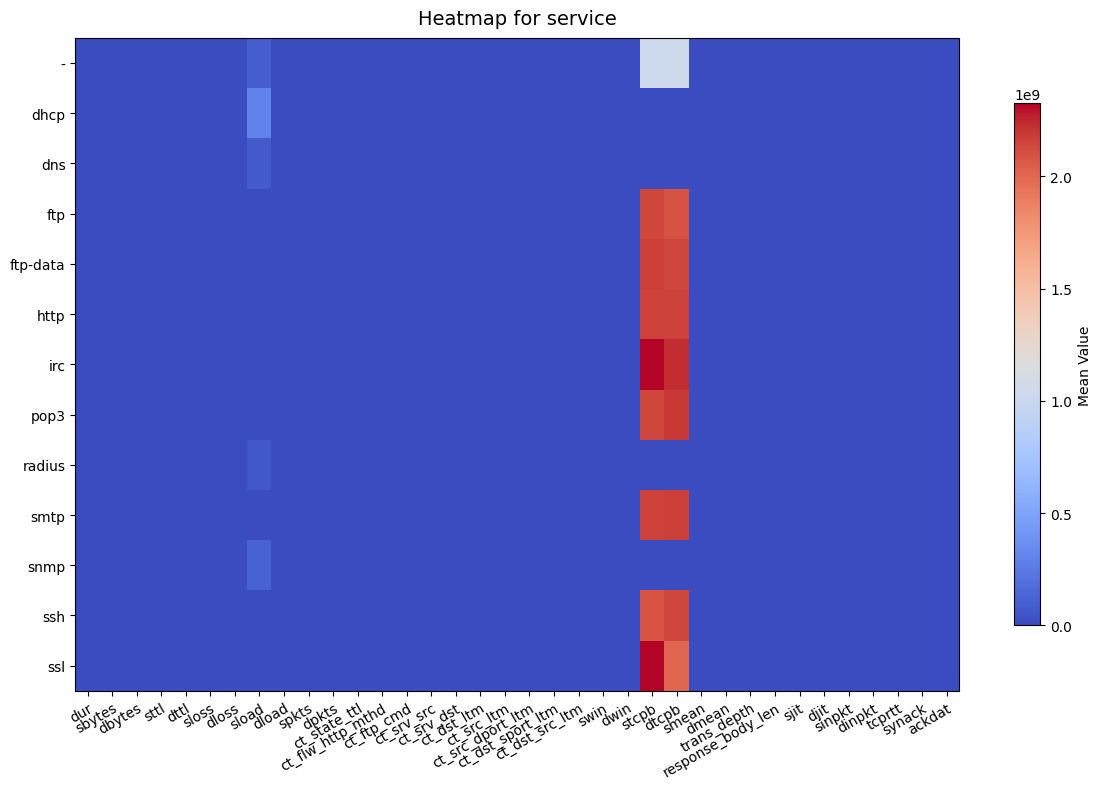

##### Correlation between proto and non-categorical columns

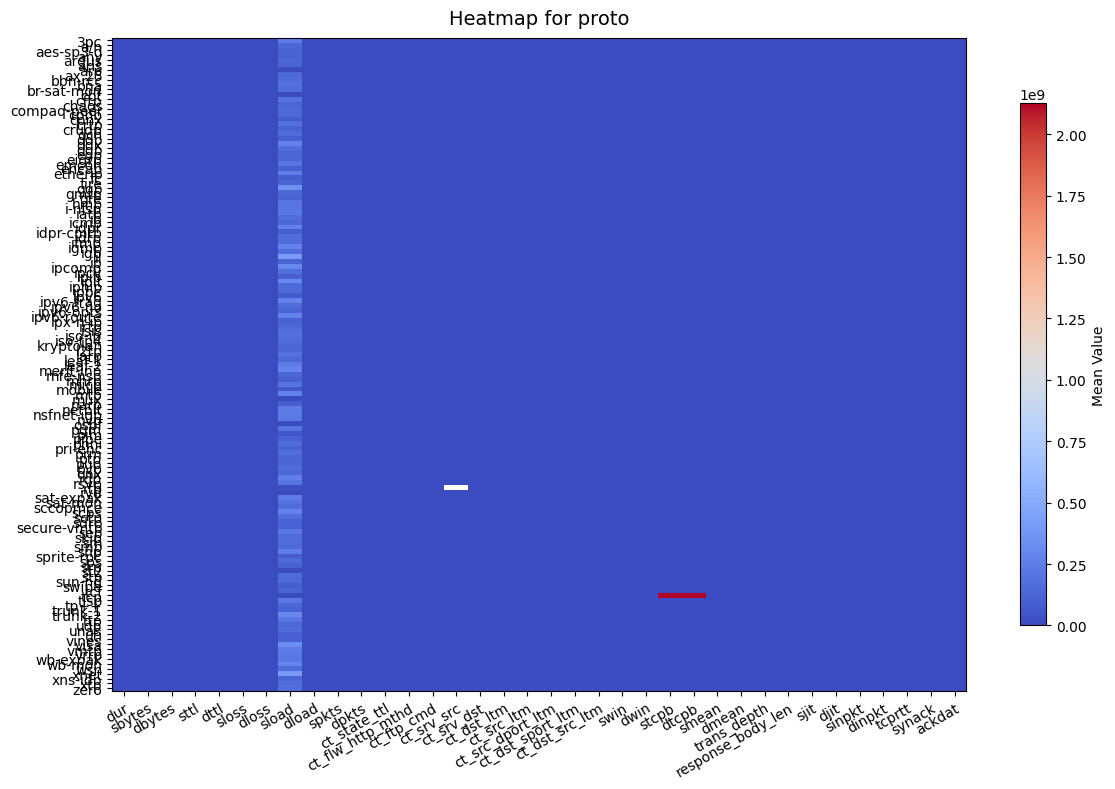

##### Correlation between is_ftp_login and non-categorical columns

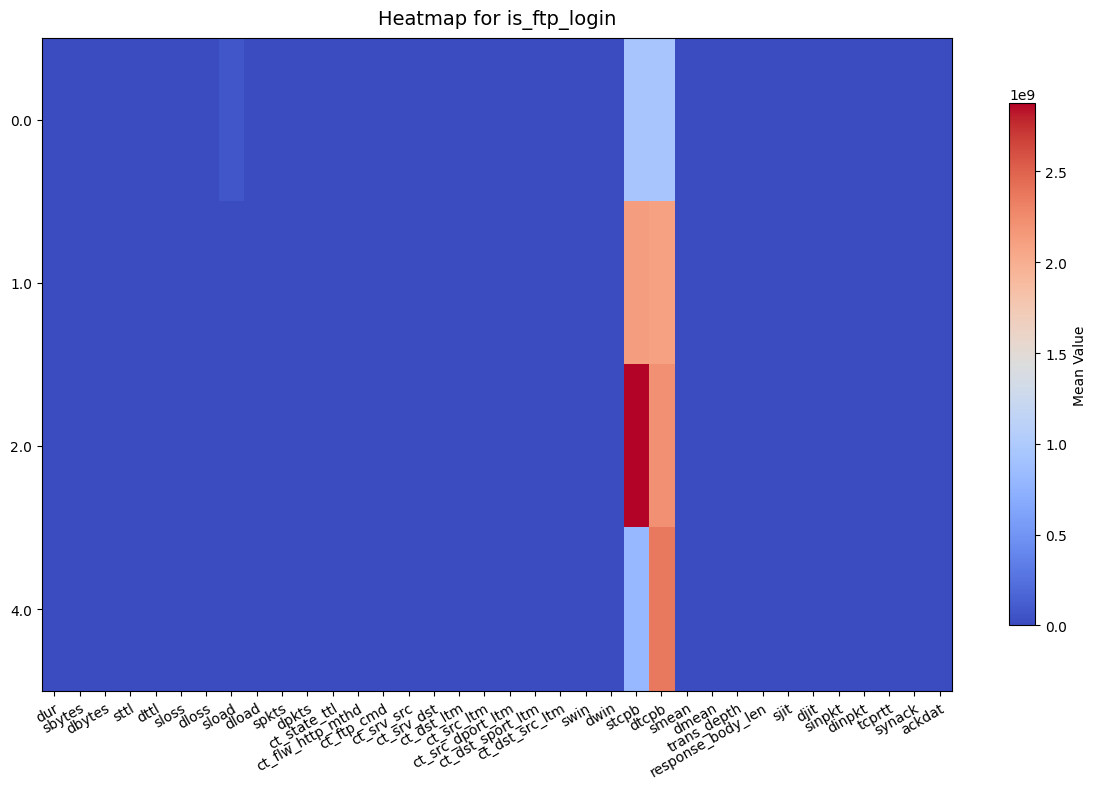

##### Correlation between is_sm_ips_ports and non-categorical columns

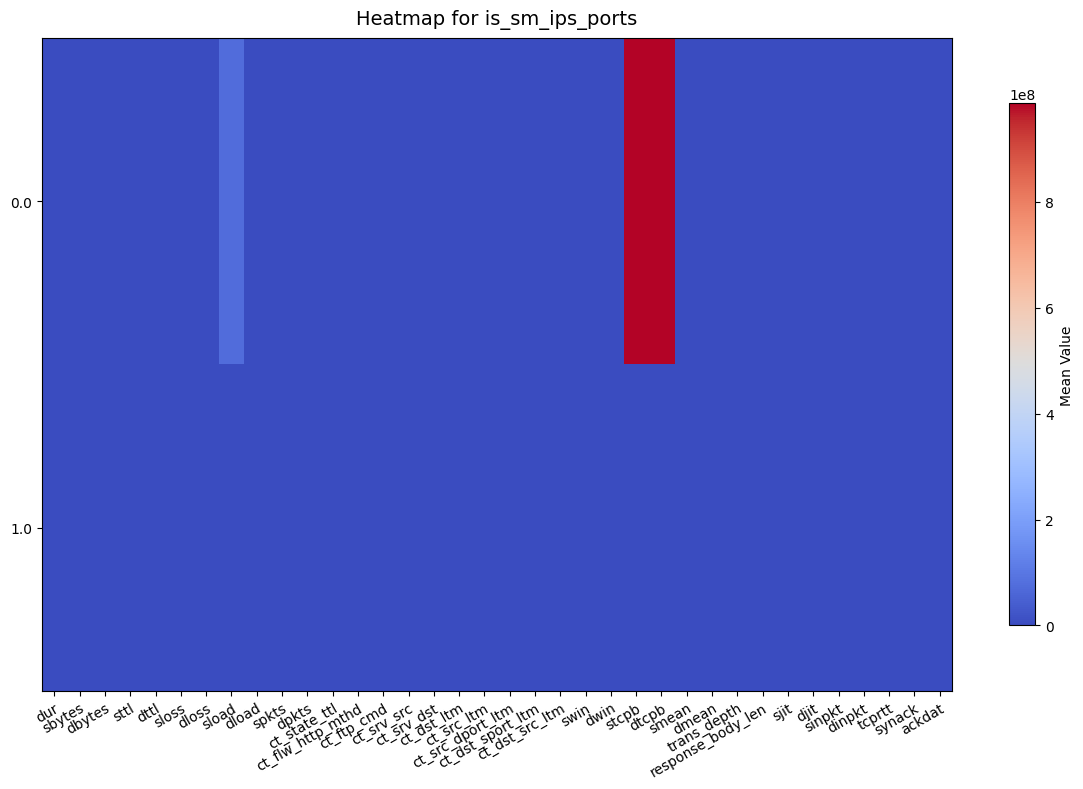

In [61]:
print_markdown("#### Visualization of Correlation between Categorical Features and Non-Categorical Features")

for cat_col in categorical_features:
    print_markdown(f"##### Correlation between {cat_col} and non-categorical columns")
    pivot_table = df.groupby(cat_col)[numerical_features].mean()

    fig, ax = plt.subplots(figsize=(12, 8))  
    im = ax.imshow(pivot_table, aspect="auto", cmap="coolwarm") 

    ax.set_xticks(np.arange(len(numerical_features)))
    ax.set_xticklabels(numerical_features, fontsize=10)
    ax.set_yticks(np.arange(len(pivot_table.index)))
    ax.set_yticklabels(pivot_table.index, fontsize=10)

    plt.setp(ax.get_xticklabels(), rotation=30, ha="right", rotation_mode="anchor")

    ax.set_title(f"Heatmap for {cat_col}", fontsize=14, pad=10)
    plt.colorbar(im, ax=ax, shrink=0.8, label="Mean Value") 

    fig.tight_layout()
    plt.show()

#### Visualization of Correlation between Non-Categorical Features and Target Variable

##### Correlation between attack_cat column and non-categorical columns

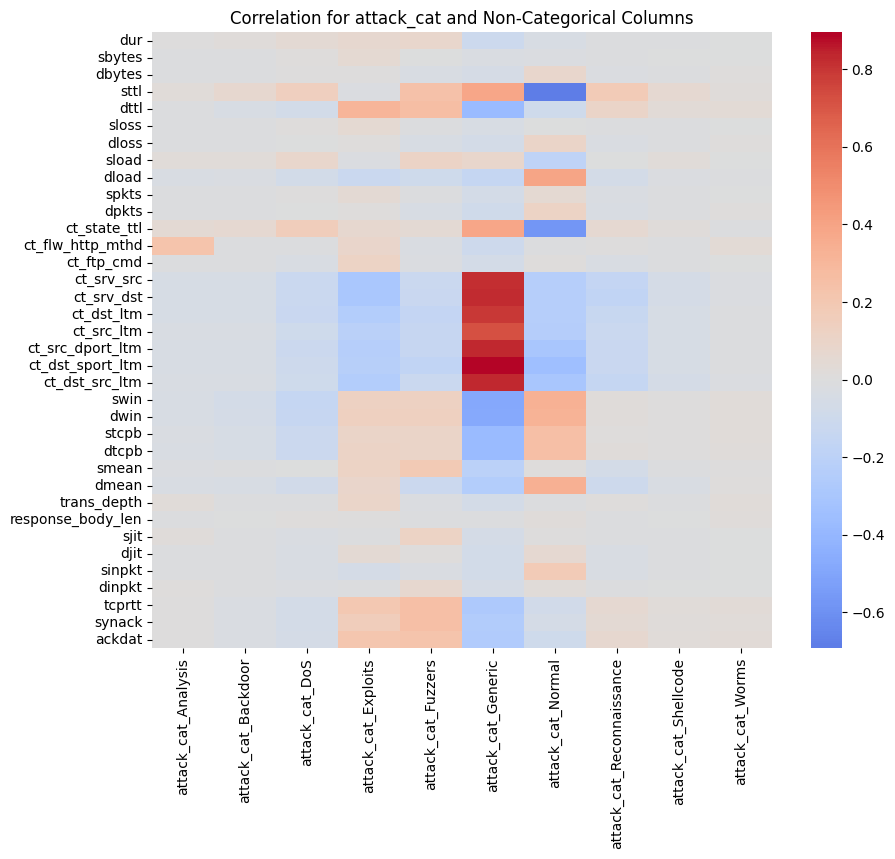

In [62]:
print_markdown("#### Visualization of Correlation between Non-Categorical Features and Target Variable")

for target in target_col:
    print_markdown(f"##### Correlation between {target} column and non-categorical columns")
    df_encoded = pd.get_dummies(df[target], prefix=target)

    df_combined = pd.concat([df[numerical_features], df_encoded], axis=1)
    correlation_matrix = df_combined.corr()
    correlations = correlation_matrix.loc[numerical_features, df_encoded.columns]
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlations, annot=False, cmap="coolwarm", center=0)
    plt.title(f"Correlation for {target} and Non-Categorical Columns")
    plt.show()

# 1. Split Training Set and Validation Set

Splitting the training and validation set works as an early diagnostic towards the performance of the model we train. This is done before the preprocessing steps to **avoid data leakage inbetween the sets**. If you want to use k-fold cross-validation, split the data later and do the cleaning and preprocessing separately for each split.

Note: For training, you should use the data contained in the `train` folder given by the TA. The `test` data is only used for kaggle submission.

#### We are using k-fold cross validation.

# 2. Data Cleaning and Preprocessing

This step is the first thing to be done once a Data Scientist have grasped a general knowledge of the data. Raw data is **seldom ready for training**, therefore steps need to be taken to clean and format the data for the Machine Learning model to interpret.

By performing data cleaning and preprocessing, you ensure that your dataset is ready for model training, leading to more accurate and reliable machine learning results. These steps are essential for transforming raw data into a format that machine learning algorithms can effectively learn from and make predictions.

We will give some common methods for you to try, but you only have to **at least implement one method for each process**. For each step that you will do, **please explain the reason why did you do that process. Write it in a markdown cell under the code cell you wrote.**

## A. Data Cleaning

**Data cleaning** is the crucial first step in preparing your dataset for machine learning. Raw data collected from various sources is often messy and may contain errors, missing values, and inconsistencies. Data cleaning involves the following steps:

1. **Handling Missing Data:** Identify and address missing values in the dataset. This can include imputing missing values, removing rows or columns with excessive missing data, or using more advanced techniques like interpolation.

2. **Dealing with Outliers:** Identify and handle outliers, which are data points significantly different from the rest of the dataset. Outliers can be removed or transformed to improve model performance.

3. **Data Validation:** Check for data integrity and consistency. Ensure that data types are correct, categorical variables have consistent labels, and numerical values fall within expected ranges.

4. **Removing Duplicates:** Identify and remove duplicate rows, as they can skew the model's training process and evaluation metrics.

5. **Feature Engineering**: Create new features or modify existing ones to extract relevant information. This step can involve scaling, normalizing, or encoding features for better model interpretability.

### I. Handling Missing Data

Missing data can adversely affect the performance and accuracy of machine learning models. There are several strategies to handle missing data in machine learning:

1. **Data Imputation:**

    a. **Mean, Median, or Mode Imputation:** For numerical features, you can replace missing values with the mean, median, or mode of the non-missing values in the same feature. This method is simple and often effective when data is missing at random.

    b. **Constant Value Imputation:** You can replace missing values with a predefined constant value (e.g., 0) if it makes sense for your dataset and problem.

    c. **Imputation Using Predictive Models:** More advanced techniques involve using predictive models to estimate missing values. For example, you can train a regression model to predict missing numerical values or a classification model to predict missing categorical values.

2. **Deletion of Missing Data:**

    a. **Listwise Deletion:** In cases where the amount of missing data is relatively small, you can simply remove rows with missing values from your dataset. However, this approach can lead to a loss of valuable information.

    b. **Column (Feature) Deletion:** If a feature has a large number of missing values and is not critical for your analysis, you can consider removing that feature altogether.

3. **Domain-Specific Strategies:**

    a. **Domain Knowledge:** In some cases, domain knowledge can guide the imputation process. For example, if you know that missing values are related to a specific condition, you can impute them accordingly.

4. **Imputation Libraries:**

    a. **Scikit-Learn:** Scikit-Learn provides a `SimpleImputer` class that can handle basic imputation strategies like mean, median, and mode imputation.

    b. **Fancyimpute:** Fancyimpute is a Python library that offers more advanced imputation techniques, including matrix factorization, k-nearest neighbors, and deep learning-based methods.

The choice of imputation method should be guided by the nature of your data, the amount of missing data, the problem you are trying to solve, and the assumptions you are willing to make.

In [63]:
# handle spesific columns
df['state'] = df['state'].fillna("-")
df['service'] = df['service'].fillna("-") 

# Handle overall data
shape_before_cleaning = df.shape

# Store the count of missing values before imputation
missing_before = df.isnull().sum()

# Impute missing values in numerical features with mean
num_imputer = SimpleImputer(strategy='mean')
df[numerical_features] = num_imputer.fit_transform(df[numerical_features])

# Impute missing values in categorical features with mode
cat_imputer = SimpleImputer(strategy='most_frequent')
df[categorical_features] = cat_imputer.fit_transform(df[categorical_features])

# Store the count of missing values after imputation
missing_after = df.isnull().sum()

# Create a DataFrame to display the before and after results
missing_summary = pd.DataFrame({
    'Before Imputation': missing_before,
    'After Imputation': missing_after
})


# Display the summary as a table
print_markdown("#### Missing Data Before and After Imputation:")
print(missing_summary)


#### Missing Data Before and After Imputation:

                   Before Imputation  After Imputation
state                              0                 0
dur                             8722                 0
sbytes                          8561                 0
dbytes                          8869                 0
sttl                            8825                 0
dttl                            8654                 0
sloss                           8794                 0
dloss                           8978                 0
service                            0                 0
sload                           8786                 0
dload                           8837                 0
spkts                           8654                 0
dpkts                           8686                 0
is_sm_ips_ports                 8746                 0
ct_state_ttl                    8635                 0
ct_flw_http_mthd                8647                 0
is_ftp_login                    8647                 0
ct_ftp_cmd

#### Handling Missing Data by Imputation
Since the percentage of missing values is relatively low around 5% for each features, thus having low impact on the actual data. To handle it, we will be using imputation by Mean for numerical features and Mode for categorical features.   

For certain features like state and service. the empty value will be assumed as not used

### II. Dealing with Outliers

Outliers are data points that significantly differ from the majority of the data. They can be unusually high or low values that do not fit the pattern of the rest of the dataset. Outliers can significantly impact model performance, so it is important to handle them properly.

Some methods to handle outliers:
1. **Imputation**: Replace with mean, median, or a boundary value.
2. **Clipping**: Cap values to upper and lower limits.
3. **Transformation**: Use log, square root, or power transformations to reduce their influence.
4. **Model-Based**: Use algorithms robust to outliers (e.g., tree-based models, Huber regression).

In [81]:
from sklearn.ensemble import IsolationForest

# Outlier Detection with Isolation Forest
rows_before_isoforest = df.shape[0]
iso_forest = IsolationForest(contamination=0.1, random_state=42, n_estimators=300)
outliers = iso_forest.fit_predict(df[numerical_features])

# Mask for outliers detected by Isolation Forest
outlier_mask = outliers == -1

# Remove rows identified as outliers
df = df[~outlier_mask]

rows_after_isoforest = df.shape[0]
rows_removed_isoforest = rows_before_isoforest - rows_after_isoforest

# Print the results of outlier removal
print(f"Data removed by Isolation Forest: {rows_removed_isoforest} rows")
print(f"Total Result Data after Isolation Forest: {df.shape[0]} rows")

# Handle Rare Categories in Categorical Features
rows_before_rare = df.shape[0]  # Record the number of rows before removing rare categories

for col in categorical_features:
    # Count the frequency of each category in the column
    category_counts = df[col].value_counts()

    # Set a threshold for rarity 
    threshold = 0.0001 * len(df)  # 0.01% apperance
    
    # Find the rare categories that appear less than the threshold
    rare_categories = category_counts[category_counts < threshold].index

    # Remove rows where the category is rare
    df = df[~df[col].isin(rare_categories)]

# Calculate the amount of data removed by the rare category filter
rows_after_rare = df.shape[0]
rows_removed_rare = rows_before_rare - rows_after_rare

# Final output
print(f"Data removed by rare categories: {rows_removed_rare} rows")
print(f"Total Result Data after Removing Rare Categories: {df.shape[0]} rows")


Data removed by Isolation Forest: 15103 rows
Total Result Data after Isolation Forest: 135922 rows
Data removed by rare categories: 0 rows
Total Result Data after Removing Rare Categories: 135922 rows


### III. Remove Duplicates
Handling duplicate values is crucial because they can compromise data integrity, leading to inaccurate analysis and insights. Duplicate entries can bias machine learning models, causing overfitting and reducing their ability to generalize to new data. They also inflate the dataset size unnecessarily, increasing computational costs and processing times. Additionally, duplicates can distort statistical measures and lead to inconsistencies, ultimately affecting the reliability of data-driven decisions and reporting. Ensuring data quality by removing duplicates is essential for accurate, efficient, and consistent analysis.

In [65]:
num_duplicates = df.duplicated().sum()
print_markdown("Before duplicates removal")
print(f"Number of duplicate rows: {num_duplicates}")
print(f"Percent of duplicate: {num_duplicates/len(df)*100:.2f}%")

# Remove duplicate rows
df.drop_duplicates(inplace=True)

num_duplicates = df.duplicated().sum()
print_markdown("After duplicates removal")
print(f"Number of duplicate rows: {num_duplicates}")


Before duplicates removal

Number of duplicate rows: 6745
Percent of duplicate: 4.28%


After duplicates removal

Number of duplicate rows: 0


### IV. Data Validation

Check for data integrity and consistency. Ensure that data types are correct, categorical variables have consistent labels, and numerical values fall within expected ranges.

In [66]:
print(f"Current Data Amount:{df.shape[0]}")

### Validate Categorical Data
df = df[df['is_ftp_login'].isin([1, 0])]
df = df[df['is_sm_ips_ports'].isin([1, 0])]

print(f"Filtered Data Result:{df.shape[0]}")


Current Data Amount:151025
Filtered Data Result:151025


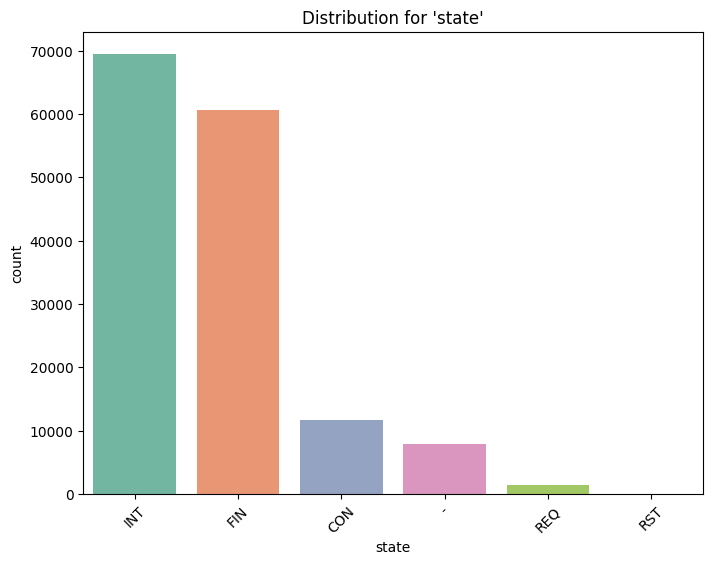

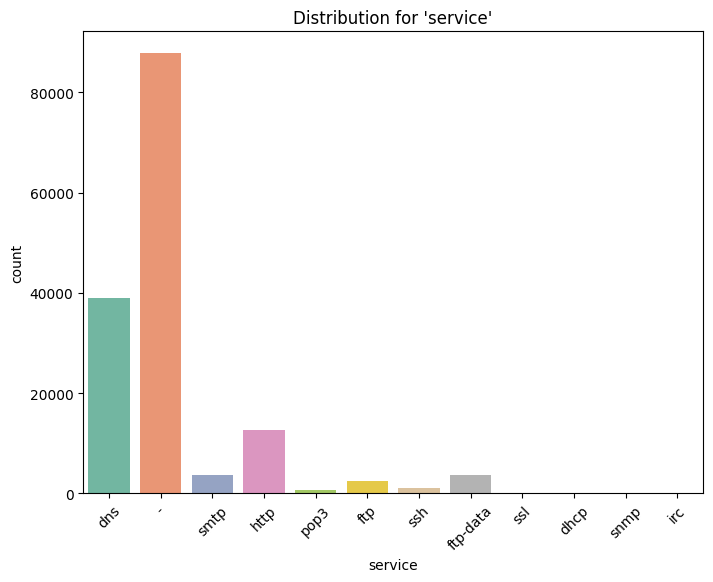

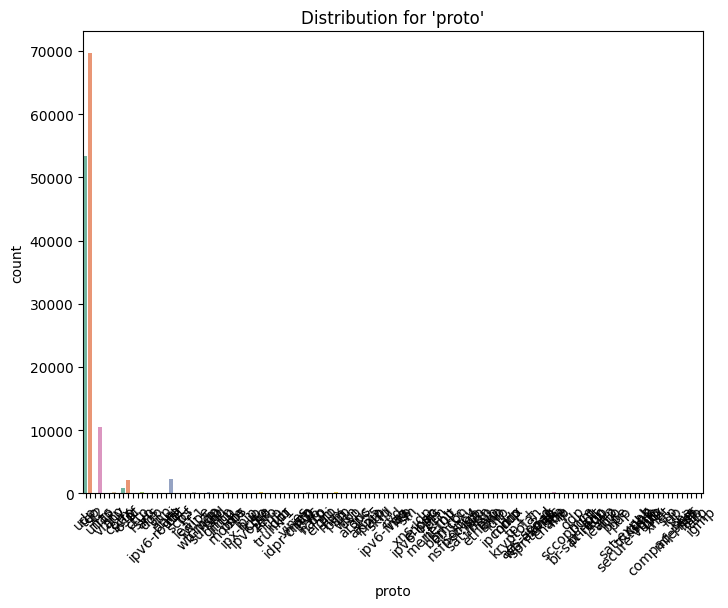

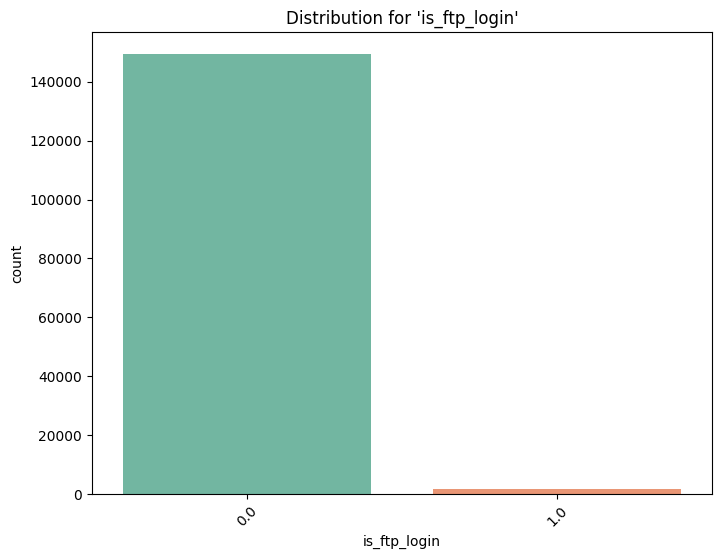

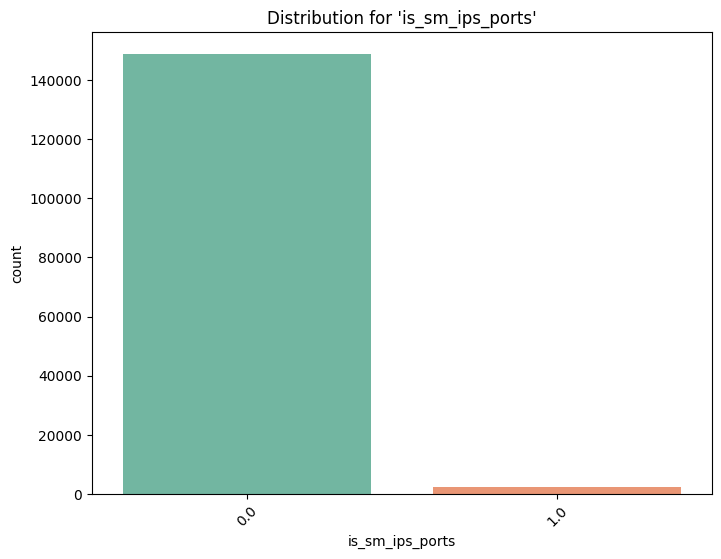

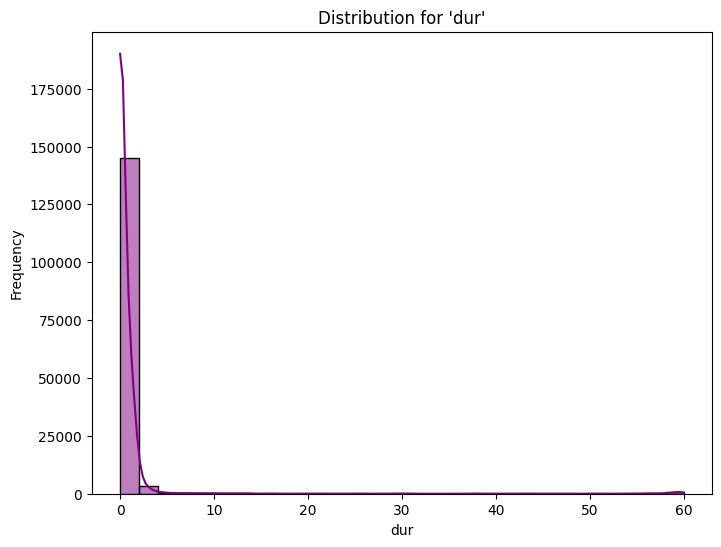

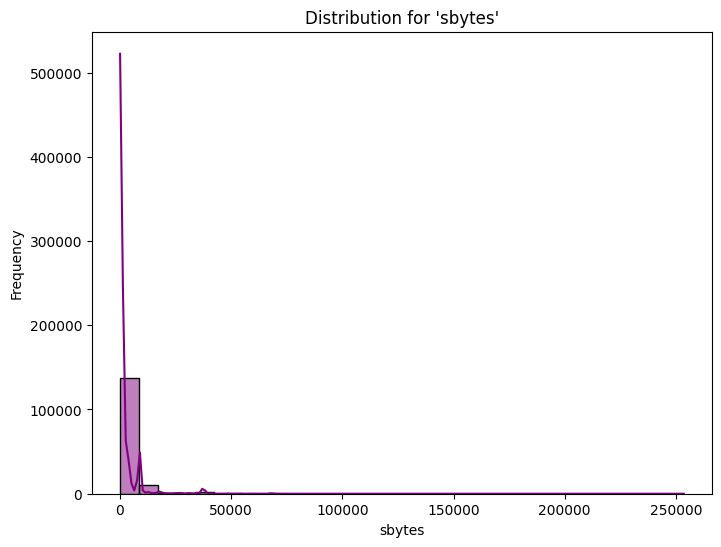

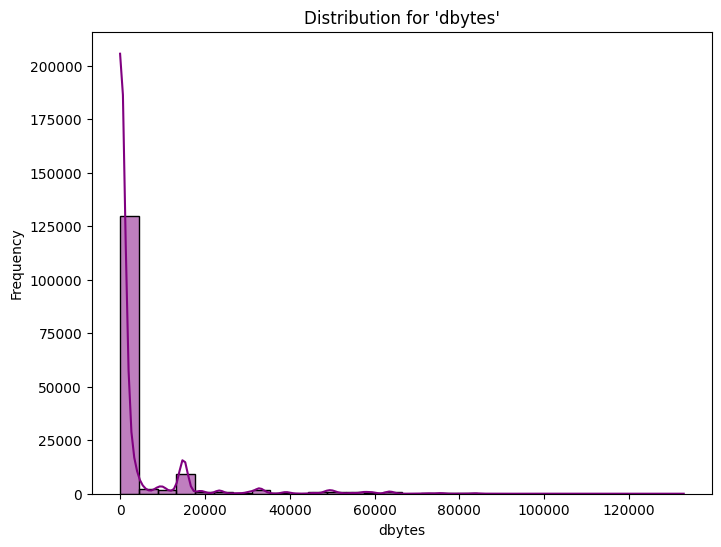

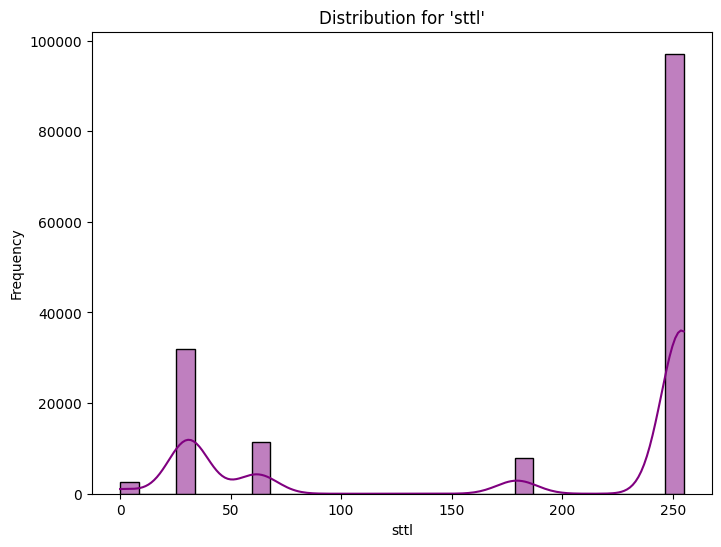

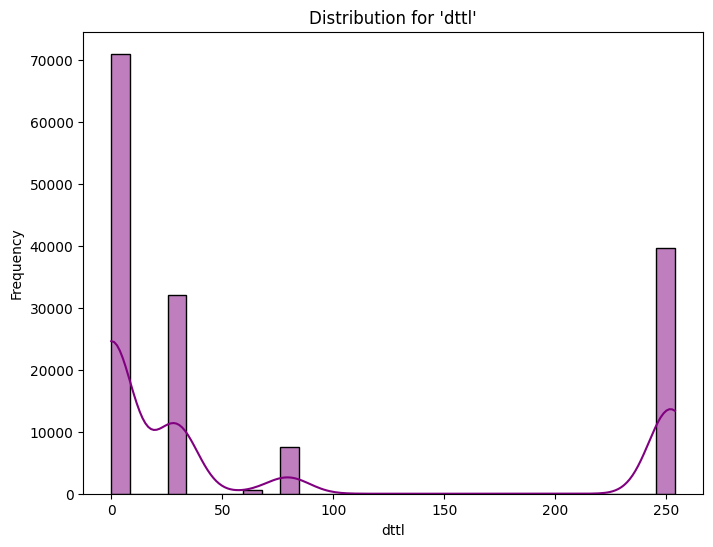

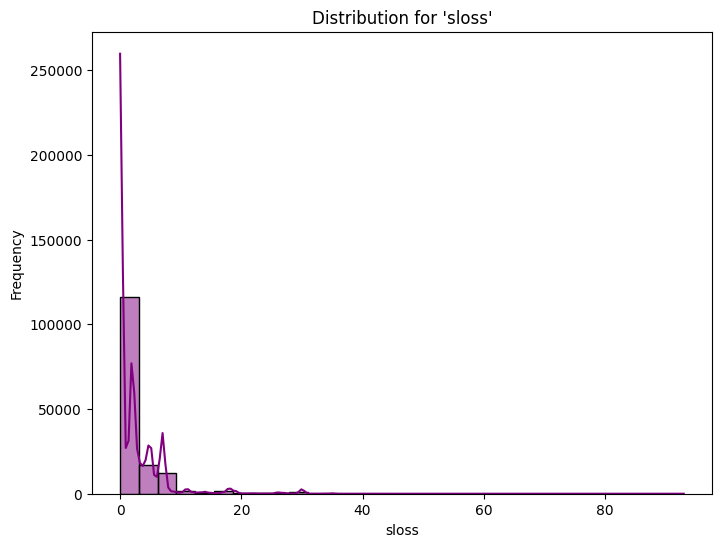

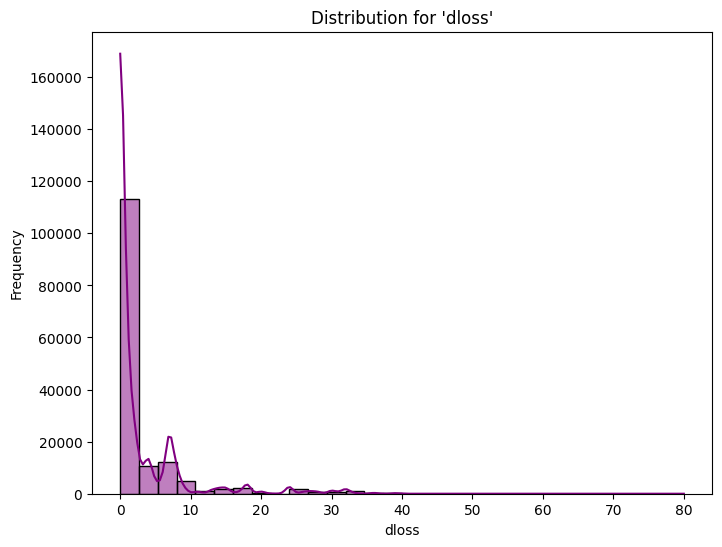

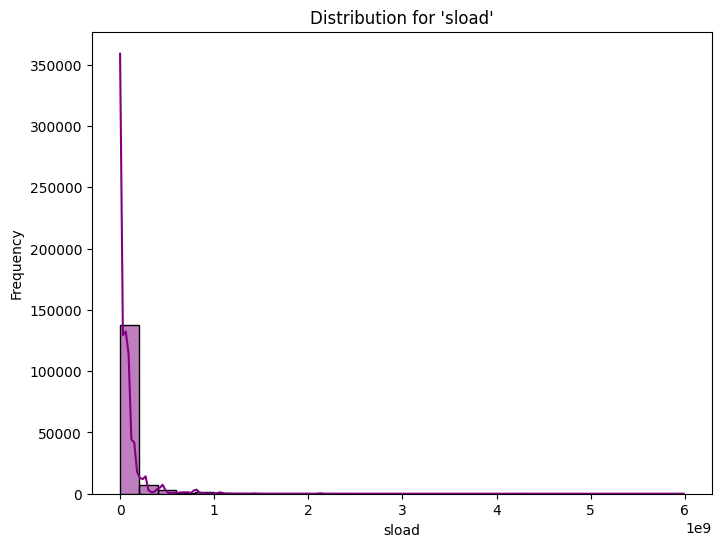

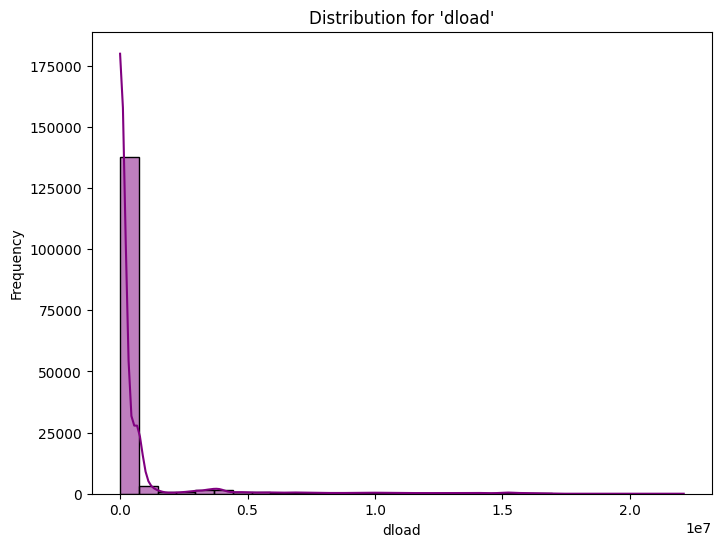

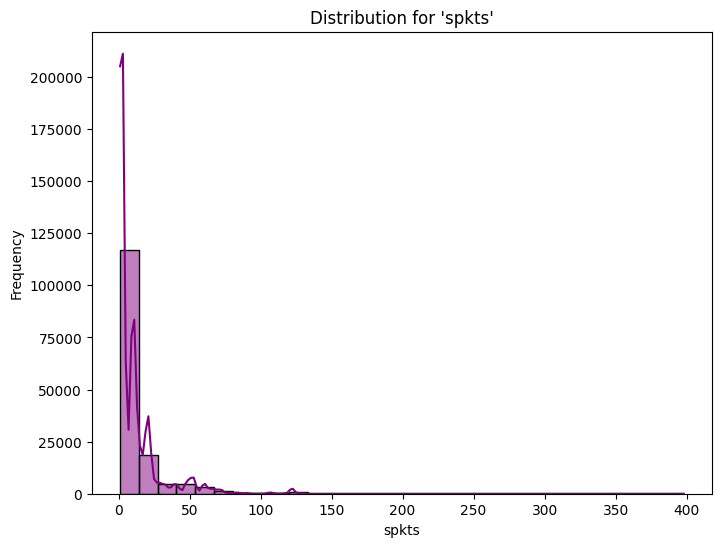

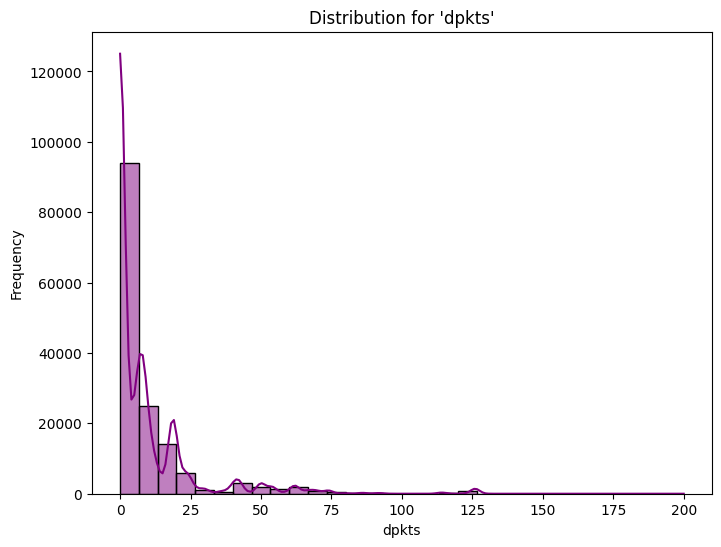

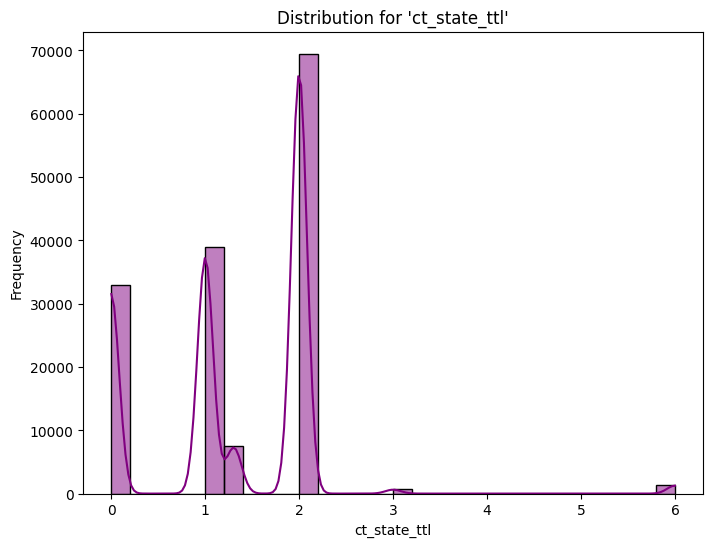

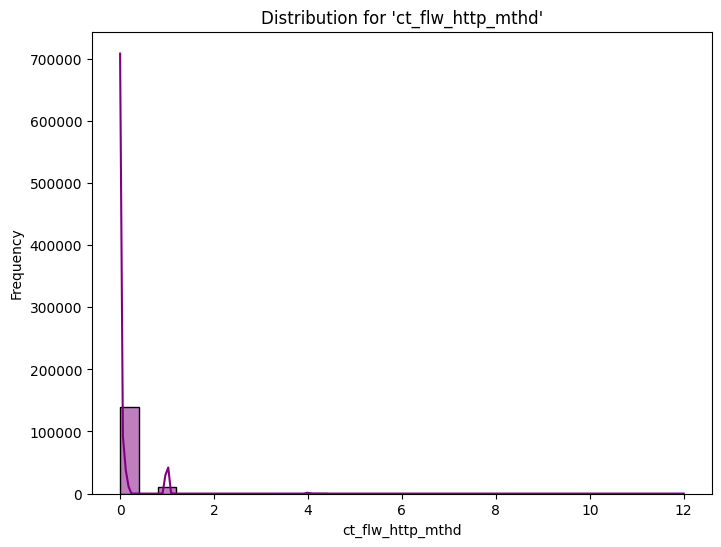

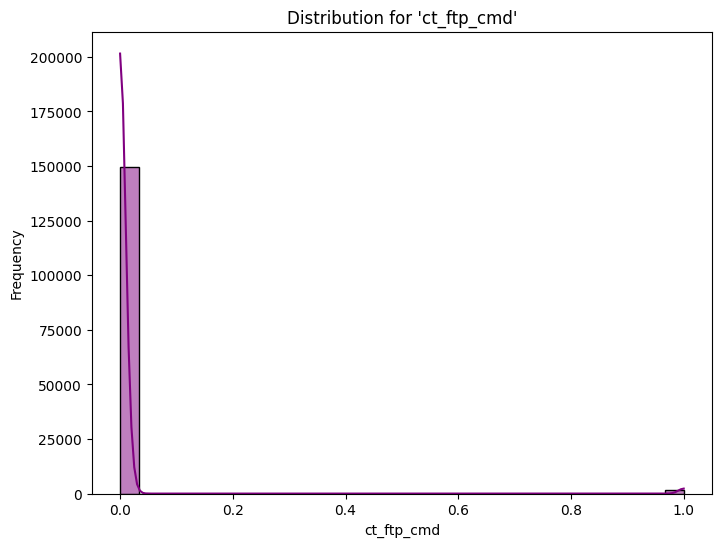

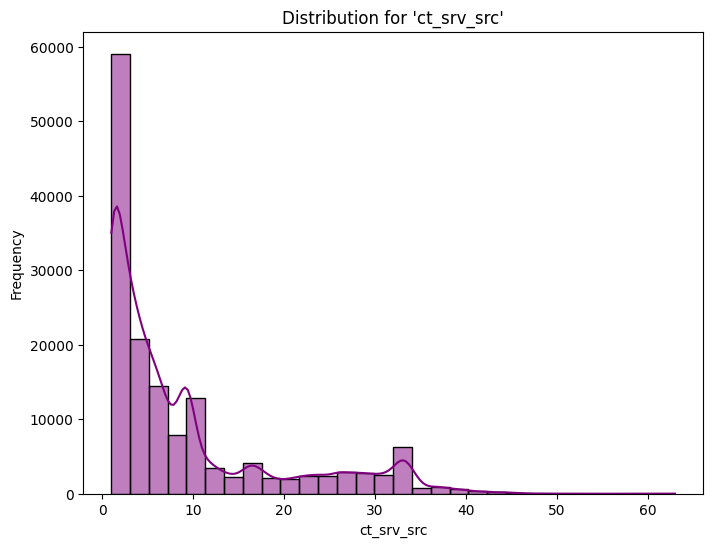

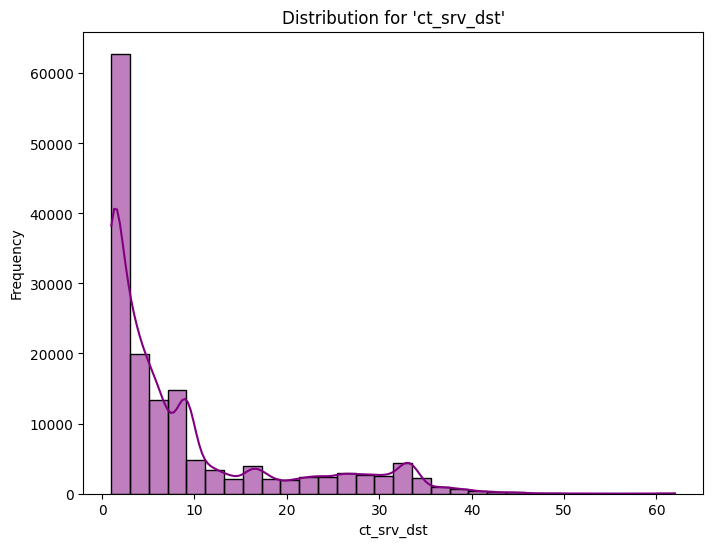

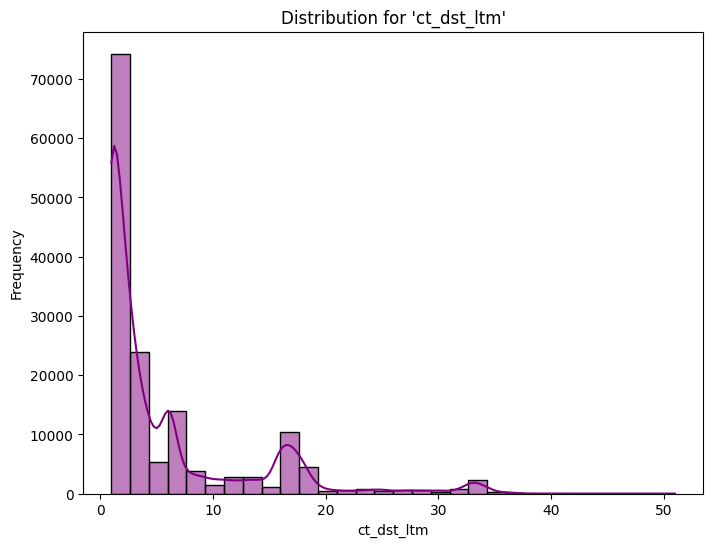

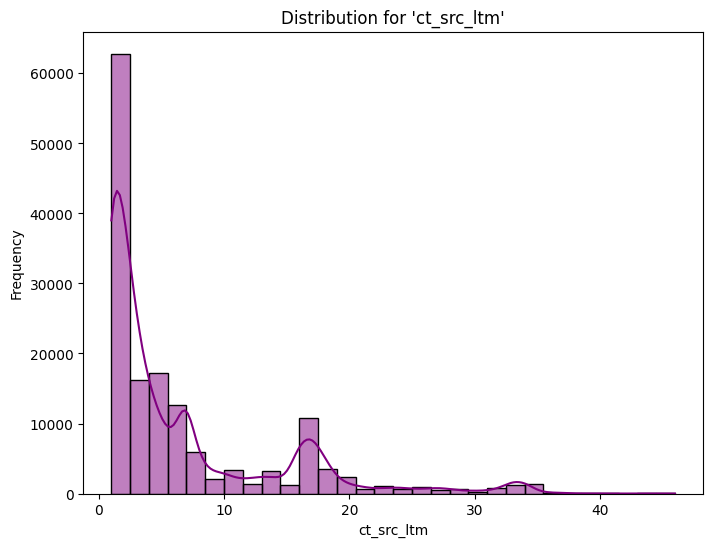

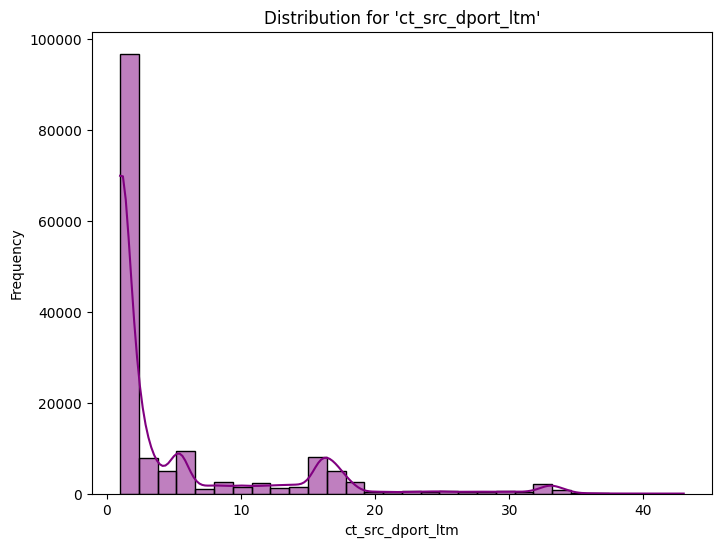

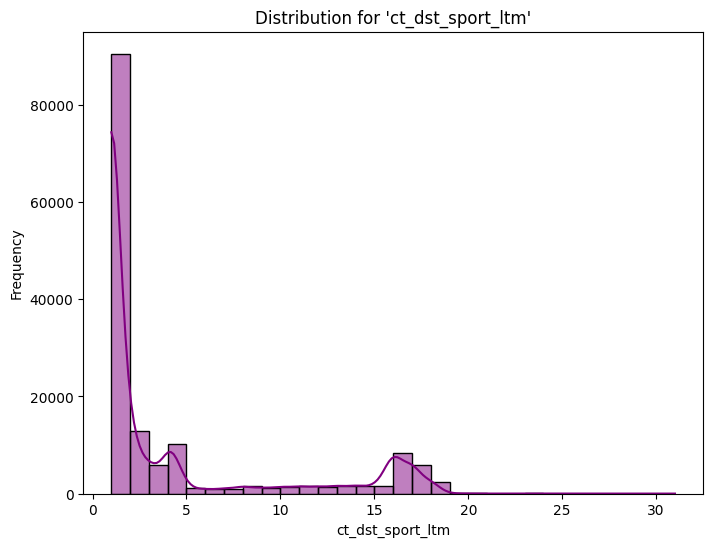

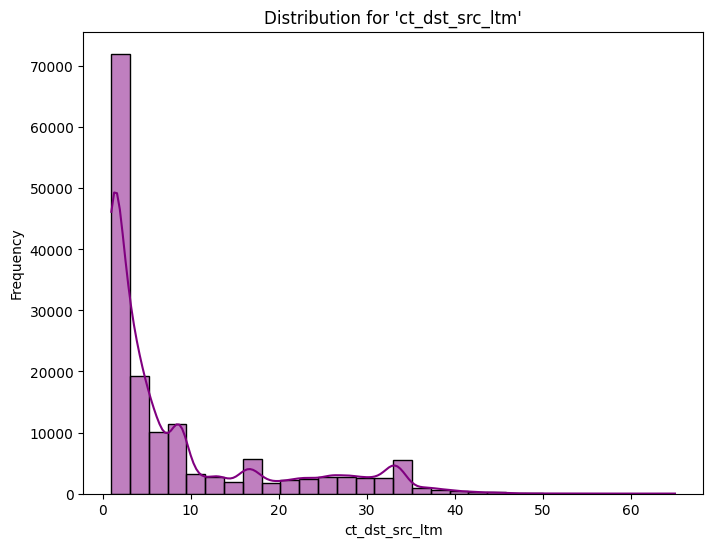

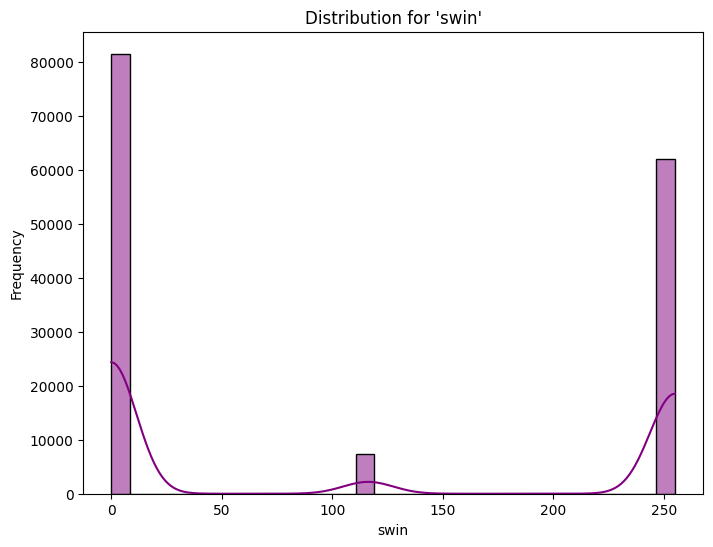

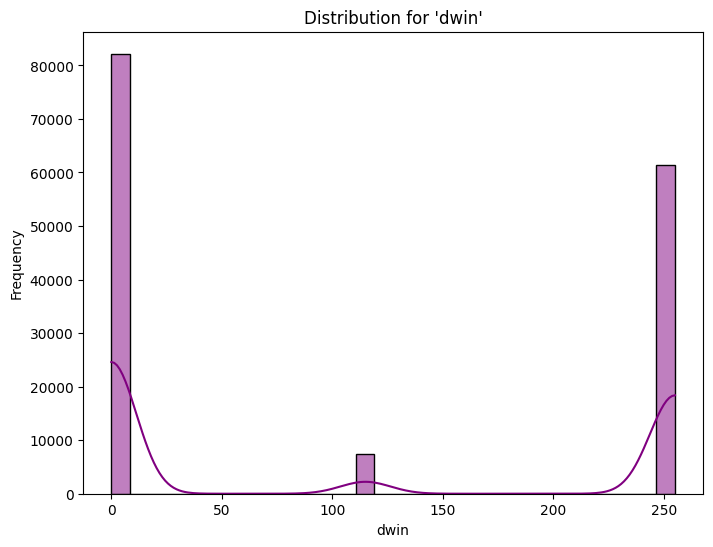

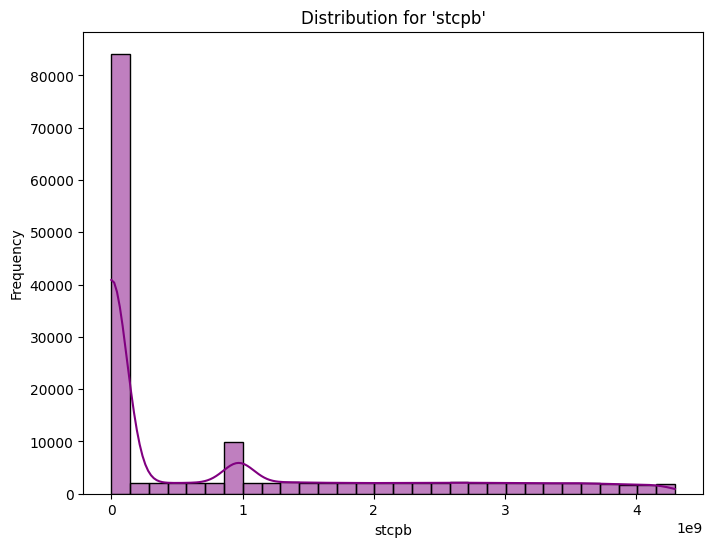

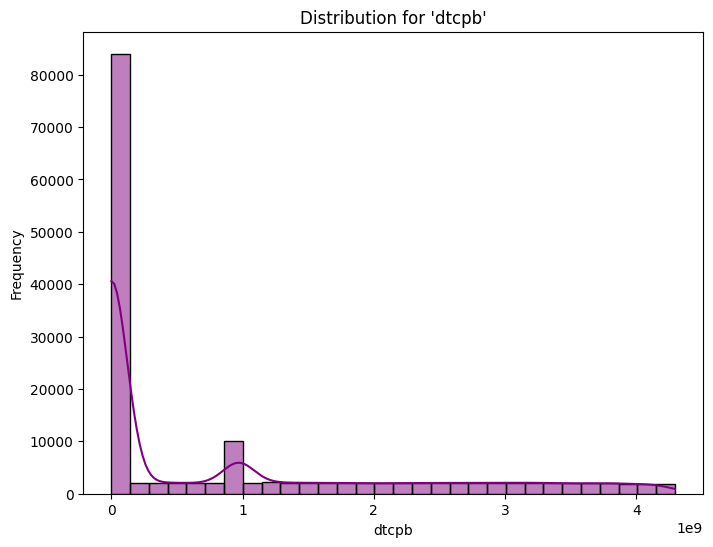

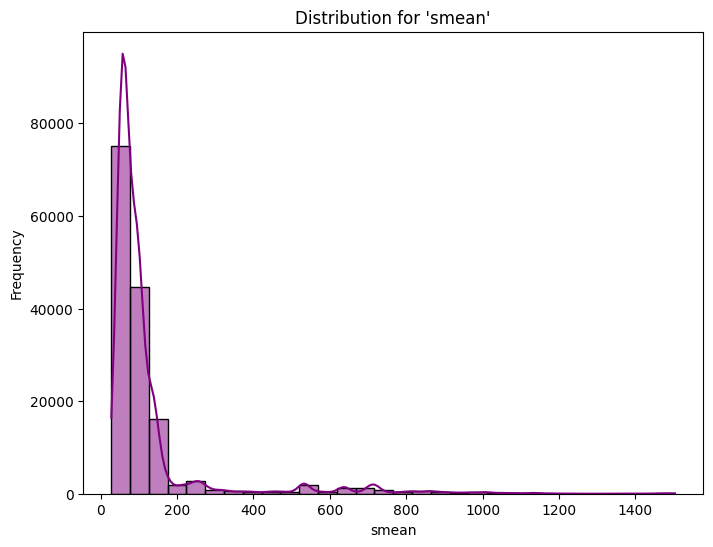

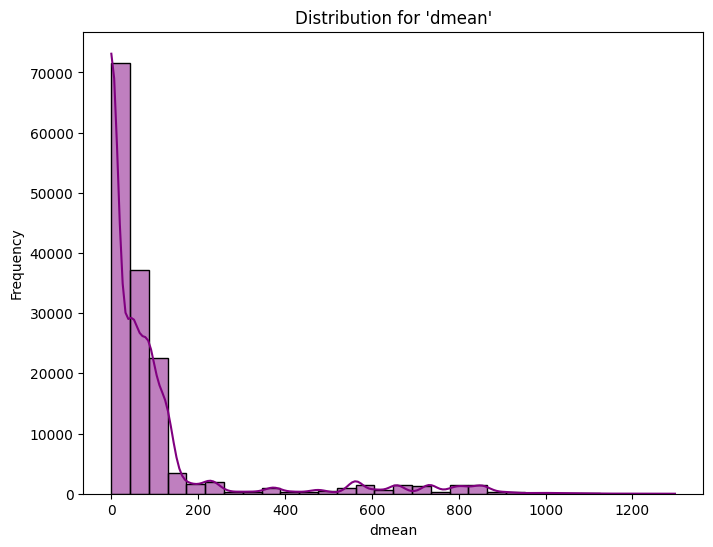

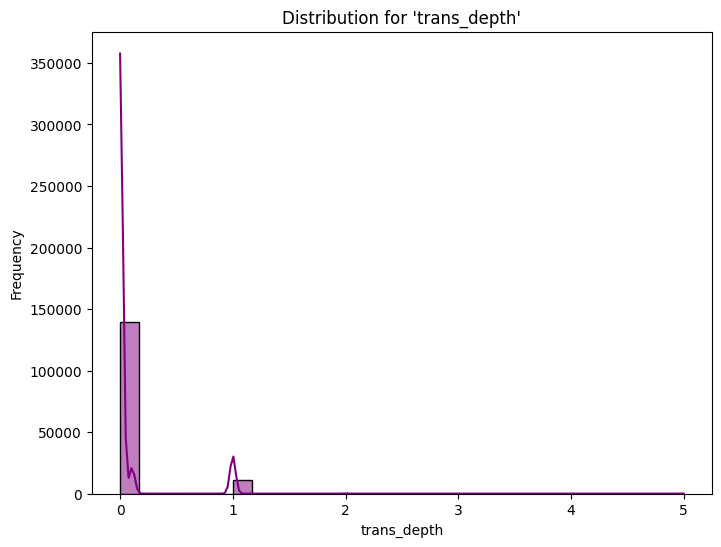

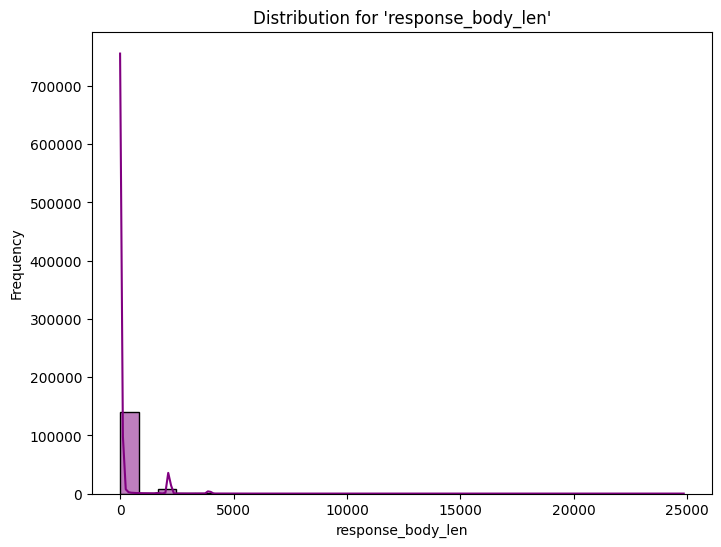

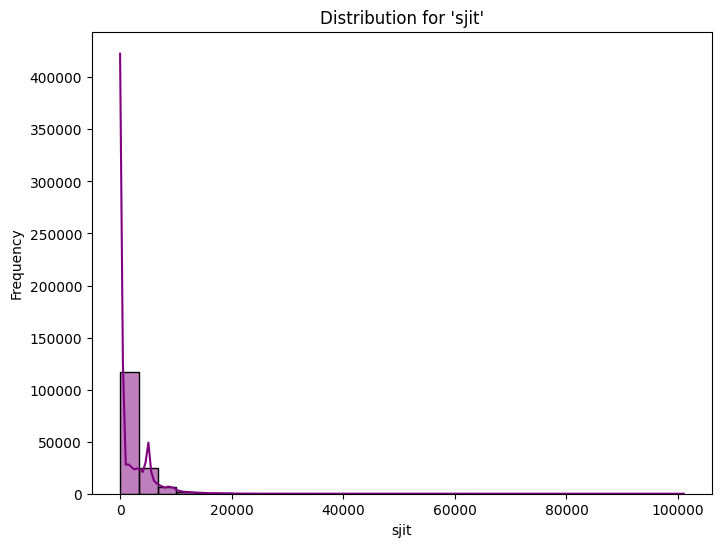

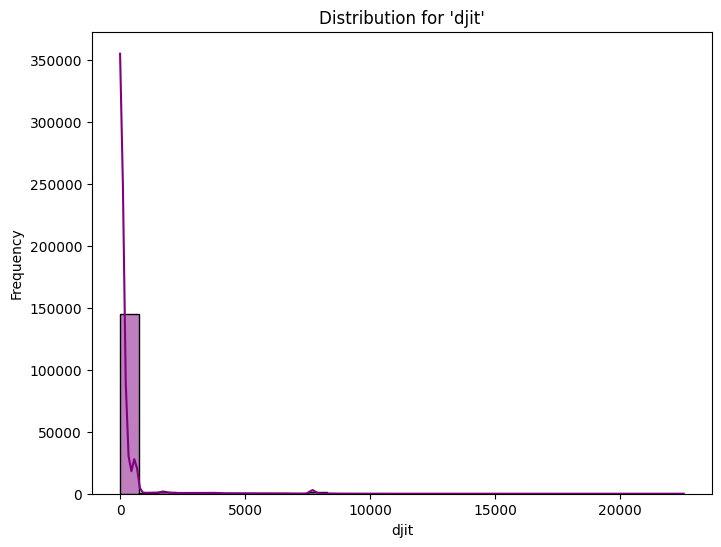

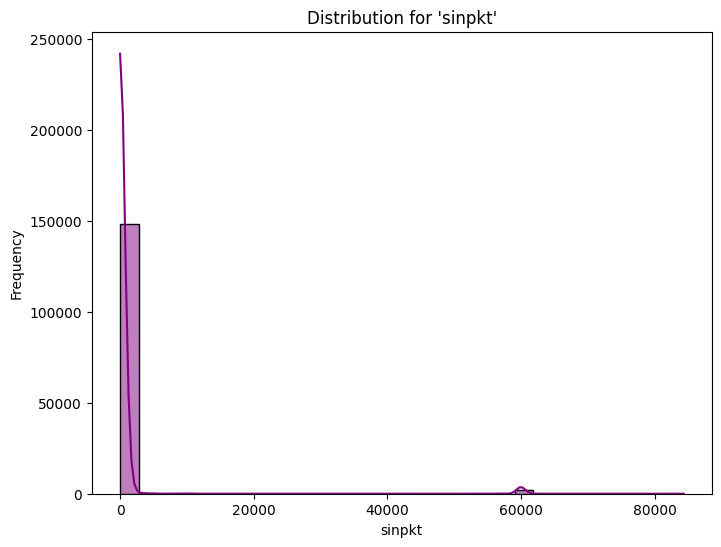

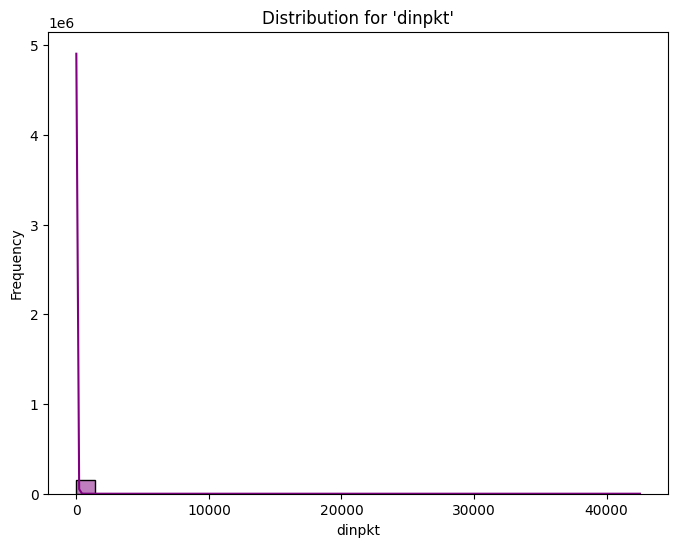

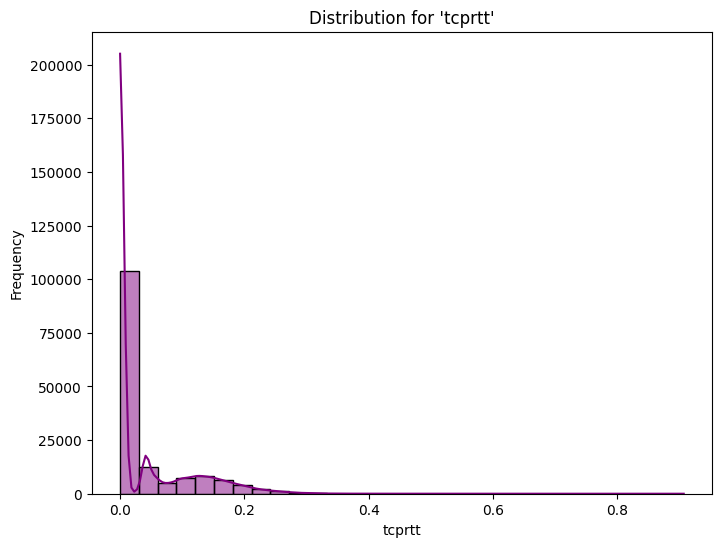

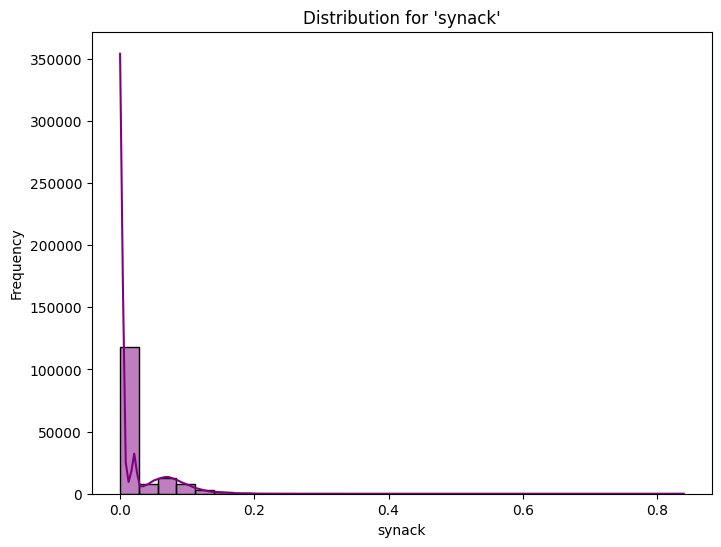

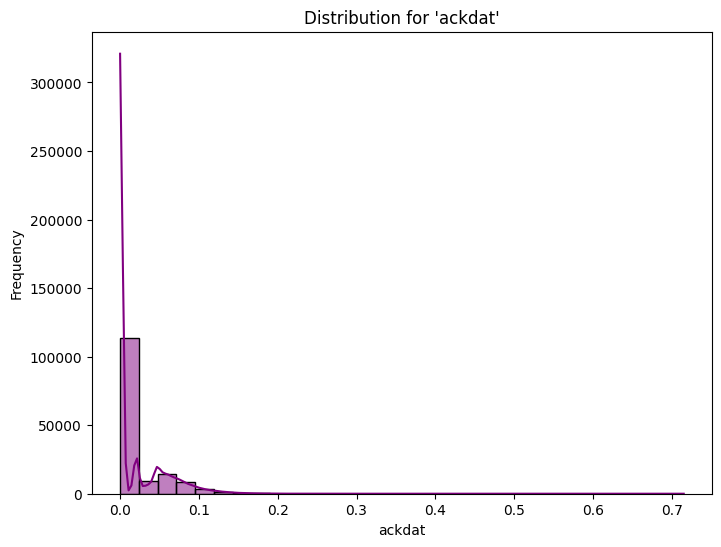

In [67]:
# Categorical column distribution plot
for col in categorical_features:
    plt.figure(figsize=(8, 6))
    sns.countplot(x=df[col].dropna(), palette='Set2', hue=df[col], legend=False)
    plt.title(f"Distribution for '{col}'")
    plt.xticks(rotation=45)
    plt.show()

# Numerical column distribution plot (using histograms)
for col in numerical_features:
    plt.figure(figsize=(8, 6))
    sns.histplot(df[col].dropna(), kde=True, bins=30, color='purple')
    plt.title(f"Distribution for '{col}'")
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

   ### V. Feature Engineering

**Feature engineering** involves creating new features (input variables) or transforming existing ones to improve the performance of machine learning models. Feature engineering aims to enhance the model's ability to learn patterns and make accurate predictions from the data. It's often said that "good features make good models."

1. **Feature Selection:** Feature engineering can involve selecting the most relevant and informative features from the dataset. Removing irrelevant or redundant features not only simplifies the model but also reduces the risk of overfitting.

2. **Creating New Features:** Sometimes, the existing features may not capture the underlying patterns effectively. In such cases, engineers create new features that provide additional information. For example:
   
   - **Polynomial Features:** Engineers may create new features by taking the square, cube, or other higher-order terms of existing numerical features. This can help capture nonlinear relationships.
   
   - **Interaction Features:** Interaction features are created by combining two or more existing features. For example, if you have features "length" and "width," you can create an "area" feature by multiplying them.

3. **Binning or Discretization:** Continuous numerical features can be divided into bins or categories. For instance, age values can be grouped into bins like "child," "adult," and "senior."

4. **Domain-Specific Feature Engineering:** Depending on the domain and problem, engineers may create domain-specific features. For example, in fraud detection, features related to transaction history and user behavior may be engineered to identify anomalies.

Feature engineering is both a creative and iterative process. It requires a deep understanding of the data, domain knowledge, and experimentation to determine which features will enhance the model's predictive power.

In [68]:
# Write your code here

In [69]:
shape_after_cleaning = df.shape
print_markdown("#### Result of Data Cleaning")
print(f"Number of instances before cleaning: {shape_before_cleaning[0]}")
print(f"Number of instance after cleaning: {shape_after_cleaning[0]}")
print(f"Number of instances removed: {shape_before_cleaning[0] - shape_after_cleaning[0]}")
print(f"Percent removed: {(shape_before_cleaning[0] - shape_after_cleaning[0])/shape_before_cleaning[0]*100:.2f}%")

#### Result of Data Cleaning

Number of instances before cleaning: 175341
Number of instance after cleaning: 151025
Number of instances removed: 24316
Percent removed: 13.87%


## B. Data Preprocessing

**Data preprocessing** is a broader step that encompasses both data cleaning and additional transformations to make the data suitable for machine learning algorithms. Its primary goals are:

1. **Feature Scaling:** Ensure that numerical features have similar scales. Common techniques include Min-Max scaling (scaling to a specific range) or standardization (mean-centered, unit variance).

2. **Encoding Categorical Variables:** Machine learning models typically work with numerical data, so categorical variables need to be encoded. This can be done using one-hot encoding, label encoding, or more advanced methods like target encoding.

3. **Handling Imbalanced Classes:** If dealing with imbalanced classes in a binary classification task, apply techniques such as oversampling, undersampling, or using different evaluation metrics to address class imbalance.

4. **Dimensionality Reduction:** Reduce the number of features using techniques like Principal Component Analysis (PCA) or feature selection to simplify the model and potentially improve its performance.

5. **Normalization:** Normalize data to achieve a standard distribution. This is particularly important for algorithms that assume normally distributed data.

### Notes on Preprocessing processes

It is advised to create functions or classes that have the same/similar type of inputs and outputs, so you can add, remove, or swap the order of the processes easily. You can implement the functions or classes by yourself

or

use `sklearn` library. To create a new preprocessing component in `sklearn`, implement a corresponding class that includes:
1. Inheritance to `BaseEstimator` and `TransformerMixin`
2. The method `fit`
3. The method `transform`

In [70]:
# Example

# from sklearn.base import BaseEstimator, TransformerMixin

# class FeatureEncoder(BaseEstimator, TransformerMixin):

#     def fit(self, X, y=None):

#         # Fit the encoder here

#         return self

#     def transform(self, X):
#         X_encoded = X.copy()

#         # Encode the categorical variables here

#         return X_encoded

### I. Feature Scaling

**Feature scaling** is a preprocessing technique used in machine learning to standardize the range of independent variables or features of data. The primary goal of feature scaling is to ensure that all features contribute equally to the training process and that machine learning algorithms can work effectively with the data.

Here are the main reasons why feature scaling is important:

1. **Algorithm Sensitivity:** Many machine learning algorithms are sensitive to the scale of input features. If the scales of features are significantly different, some algorithms may perform poorly or take much longer to converge.

2. **Distance-Based Algorithms:** Algorithms that rely on distances or similarities between data points, such as k-nearest neighbors (KNN) and support vector machines (SVM), can be influenced by feature scales. Features with larger scales may dominate the distance calculations.

3. **Regularization:** Regularization techniques, like L1 (Lasso) and L2 (Ridge) regularization, add penalty terms based on feature coefficients. Scaling ensures that all features are treated equally in the regularization process.

Common methods for feature scaling include:

1. **Min-Max Scaling (Normalization):** This method scales features to a specific range, typically [0, 1]. It's done using the following formula:

   $$X' = \frac{X - X_{min}}{X_{max} - X_{min}}$$

   - Here, $X$ is the original feature value, $X_{min}$ is the minimum value of the feature, and $X_{max}$ is the maximum value of the feature.  
<br />
<br />
2. **Standardization (Z-score Scaling):** This method scales features to have a mean (average) of 0 and a standard deviation of 1. It's done using the following formula:

   $$X' = \frac{X - \mu}{\sigma}$$

   - $X$ is the original feature value, $\mu$ is the mean of the feature, and $\sigma$ is the standard deviation of the feature.  
<br />
<br />
3. **Robust Scaling:** Robust scaling is a method that scales features to the interquartile range (IQR) and is less affected by outliers. It's calculated as:

   $$X' = \frac{X - Q1}{Q3 - Q1}$$

   - $X$ is the original feature value, $Q1$ is the first quartile (25th percentile), and $Q3$ is the third quartile (75th percentile) of the feature.  
<br />
<br />
4. **Log Transformation:** In cases where data is highly skewed or has a heavy-tailed distribution, taking the logarithm of the feature values can help stabilize the variance and improve scaling.

The choice of scaling method depends on the characteristics of your data and the requirements of your machine learning algorithm. **Min-max scaling and standardization are the most commonly used techniques and work well for many datasets.**

Scaling should be applied separately to each training and test set to prevent data leakage from the test set into the training set. Additionally, **some algorithms may not require feature scaling, particularly tree-based models.**

In [71]:
print_markdown("#### Feature Scaling")
print_markdown("Since the features have different scales, we will be using MinMaxScaler to scale the features to a range of 0 to 1.")
class FeatureScaler(BaseEstimator, TransformerMixin):

    def __init__(self, feature_range=(0,1)):
        self.feature_range = feature_range

    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        self.min = X.min(axis=0).values
        self.max = X.max(axis=0).values
        range_min, range_max = self.feature_range
        self.scale = (range_max - range_min) / (self.max - self.min)
        return self

    def transform(self, X):
        X_scaled = X.copy()
        X_scaled = pd.DataFrame(X_scaled)
        range_min, range_max = self.feature_range
        X_scaled = (X_scaled - self.min) * self.scale + range_min
        return X_scaled

#### Feature Scaling

Since the features have different scales, we will be using MinMaxScaler to scale the features to a range of 0 to 1.

### II. Feature Encoding

**Feature encoding**, also known as **categorical encoding**, is the process of converting categorical data (non-numeric data) into a numerical format so that it can be used as input for machine learning algorithms. Most machine learning models require numerical data for training and prediction, so feature encoding is a critical step in data preprocessing.

Categorical data can take various forms, including:

1. **Nominal Data:** Categories with no intrinsic order, like colors or country names.  

2. **Ordinal Data:** Categories with a meaningful order but not necessarily equidistant, like education levels (e.g., "high school," "bachelor's," "master's").

There are several common methods for encoding categorical data:

1. **Label Encoding:**

   - Label encoding assigns a unique integer to each category in a feature.
   - It's suitable for ordinal data where there's a clear order among categories.
   - For example, if you have an "education" feature with values "high school," "bachelor's," and "master's," you can encode them as 0, 1, and 2, respectively.
<br />
<br />
2. **One-Hot Encoding:**

   - One-hot encoding creates a binary (0 or 1) column for each category in a nominal feature.
   - It's suitable for nominal data where there's no inherent order among categories.
   - Each category becomes a new feature, and the presence (1) or absence (0) of a category is indicated for each row.
<br />
<br />
3. **Target Encoding (Mean Encoding):**

   - Target encoding replaces each category with the mean of the target variable for that category.
   - It's often used for classification problems.

In [72]:
# Write your code here

### III. Handling Imbalanced Dataset

**Handling imbalanced datasets** is important because imbalanced data can lead to several issues that negatively impact the performance and reliability of machine learning models. Here are some key reasons:

1. **Biased Model Performance**:

 - Models trained on imbalanced data tend to be biased towards the majority class, leading to poor performance on the minority class. This can result in misleading accuracy metrics.

2. **Misleading Accuracy**:

 - High overall accuracy can be misleading in imbalanced datasets. For example, if 95% of the data belongs to one class, a model that always predicts the majority class will have 95% accuracy but will fail to identify the minority class.

3. **Poor Generalization**:

 - Models trained on imbalanced data may not generalize well to new, unseen data, especially if the minority class is underrepresented.


Some methods to handle imbalanced datasets:
1. **Resampling Methods**:

 - Oversampling: Increase the number of instances in the minority class by duplicating or generating synthetic samples (e.g., SMOTE).
 - Undersampling: Reduce the number of instances in the majority class to balance the dataset.

2. **Evaluation Metrics**:

 - Use appropriate evaluation metrics such as precision, recall, F1-score, ROC-AUC, and confusion matrix instead of accuracy to better assess model performance on imbalanced data.

3. **Algorithmic Approaches**:

 - Use algorithms that are designed to handle imbalanced data, such as decision trees, random forests, or ensemble methods.
 - Adjust class weights in algorithms to give more importance to the minority class.

In [73]:
# Write your code here

### IV. Data Normalization

Data normalization is used to achieve a standard distribution. Without normalization, models or processes that rely on the assumption of normality may not work correctly. Normalization helps reduce the magnitude effect and ensures numerical stability during optimization.

In [74]:
# Write your code here

### V. Dimensionality Reduction

Dimensionality reduction is a technique used in data preprocessing to reduce the number of input features (dimensions) in a dataset while retaining as much important information as possible. It is essential when dealing with high-dimensional data, where too many features can cause problems like increased computational costs, overfitting, and difficulty in visualization. Reducing dimensions simplifies the data, making it easier to analyze and improving the performance of machine learning models.

One of the main approaches to dimensionality reduction is feature extraction. Feature extraction creates new, smaller sets of features that capture the essence of the original data. Common techniques include:

1. **Principal Component Analysis (PCA)**: Converts correlated features into a smaller number of uncorrelated "principal components."
2. **t-SNE (t-Distributed Stochastic Neighbor Embedding)**: A visualization-focused method to project high-dimensional data into 2D or 3D spaces.
3. **Autoencoders**: Neural networks that learn compressed representations of the data.

In [75]:
# Write your code here

# 3. Compile Preprocessing Pipeline

All of the preprocessing classes or functions defined earlier will be compiled in this step.

If you use sklearn to create preprocessing classes, you can list your preprocessing classes in the Pipeline object sequentially, and then fit and transform your data.

In [76]:
# from sklearn.pipeline import Pipeline

# # Note: You can add or delete preprocessing components from this pipeline

# pipe = Pipeline([("imputer", FeatureImputer()),
#                  ("featurecreator", FeatureCreator()),
#                  ("scaler", FeatureScaler()),
#                  ("encoder", FeatureEncoder())])

# train_set = pipe.fit_transform(train_set)
# val_set = pipe.transform(val_set)

In [77]:
# # Your code should work up until this point
# train_set = pipe.fit_transform(train_set)
# val_set = pipe.transform(val_set)

or create your own here

In [78]:
# Write your code here

# 4. Modeling and Validation

Modelling is the process of building your own machine learning models to solve specific problems, or in this assignment context, predicting the target feature `attack_cat`. Validation is the process of evaluating your trained model using the validation set or cross-validation method and providing some metrics that can help you decide what to do in the next iteration of development.

In [79]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import log_loss, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

## A. KNN

In [80]:
train_KNN = train_cleaned_d1.copy()

NameError: name 'train_cleaned_d1' is not defined

In [ ]:
status_encoder = LabelEncoder()
train_KNN['Status'] = status_encoder.fit_transform(train_KNN['Status'])

X = train_KNN.drop(['id', 'Status'], axis=1)
y = train_KNN['Status']

categorical_columns = ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Stage']
numerical_columns = X.select_dtypes(include=['float64']).columns.drop('Stage').to_list()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_columns),
        ("cat", OneHotEncoder(), categorical_columns)
    ]
)

k = 200
knn_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", KNeighborsClassifier(n_neighbors=k))
])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
knn_pipeline.fit(X_train, y_train)

y_pred = knn_pipeline.predict_proba(X_val)
accuracy = accuracy_score(y_val, knn_pipeline.predict(X_val))
f1 = f1_score(y_val, knn_pipeline.predict(X_val), average='weighted')
logloss = log_loss(y_val, y_pred)
report = classification_report(y_val, knn_pipeline.predict(X_val))

print(f"Validation Accuracy with KNN: {accuracy:.4f}")
print(f"Validation Log Loss with KNN: {logloss:.4f}")
print(f"Validation F1 Score with KNN: {f1:.4f}")
print(report)

test_ids = test['id']
X_test = test.drop(['id'], axis=1)

test_probs = knn_pipeline.predict_proba(X_test)

submission = pd.DataFrame(
    test_probs,
    columns=[f"Status_{cls}" for cls in status_encoder.classes_]
)
submission.insert(0, 'id', test_ids)

submission.to_csv('submission_KNN.csv', index=False)
print("Submission file saved as submission_KNN.csv")

## B. Naive Bayes

In [19]:
# Type your code here

## C. ID3

In [20]:
# Type your code here

## D. Improvements (Optional)

- **Visualize the model evaluation result**

This will help you to understand the details more clearly about your model's performance. From the visualization, you can see clearly if your model is leaning towards a class than the others. (Hint: confusion matrix, ROC-AUC curve, etc.)

- **Explore the hyperparameters of your models**

Each models have their own hyperparameters. And each of the hyperparameter have different effects on the model behaviour. You can optimize the model performance by finding the good set of hyperparameters through a process called **hyperparameter tuning**. (Hint: Grid search, random search, bayesian optimization)

- **Cross-validation**

Cross-validation is a critical technique in machine learning and data science for evaluating and validating the performance of predictive models. It provides a more **robust** and **reliable** evaluation method compared to a hold-out (single train-test set) validation. Though, it requires more time and computing power because of how cross-validation works. (Hint: k-fold cross-validation, stratified k-fold cross-validation, etc.)

In [21]:
# Type your code here

## E. Submission
To predict the test set target feature and submit the results to the kaggle competition platform, do the following:
1. Create a new pipeline instance identical to the first in Data Preprocessing
2. With the pipeline, apply `fit_transform` to the original training set before splitting, then only apply `transform` to the test set.
3. Retrain the model on the preprocessed training set
4. Predict the test set
5. Make sure the submission contains the `id` and `attack_cat` column.

In [22]:
# Type your code here

# 6. Error Analysis

Based on all the process you have done until the modeling and evaluation step, write an analysis to support each steps you have taken to solve this problem. Write the analysis using the markdown block. Some questions that may help you in writing the analysis:

- Does my model perform better in predicting one class than the other? If so, why is that?
- To each models I have tried, which performs the best and what could be the reason?
- Is it better for me to impute or drop the missing data? Why?
- Does feature scaling help improve my model performance?
- etc...

`Provide your analysis here`